In [80]:
import re
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

from tqdm import tqdm
tqdm.pandas() 

from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder

In [1723]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
y = train['target']

train.drop(columns=['target'], axis=1, inplace=True)
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
train['is_test'] = 0
test['is_test'] = 1

concat = pd.concat([train, test], ignore_index=True)     # 하나의 데이터로 만들어줍니다.
concat.reset_index(drop=True, inplace=True)
print(len(train) + len(test), len(concat))

pre_df = pd.DataFrame()
pre_df['is_test'] = concat['is_test']
pre_df.reset_index(drop=True, inplace=True)
pre_train = pd.DataFrame()
pre_test = pd.DataFrame()
print(len(pre_df), len(concat))

/tmp/ipykernel_673659/1519268164.py:1: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("../data/train.csv")


1128094 1128094
1128094 1128094


In [1724]:
concat.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'is_test'],
      dtype='object')

# 번지 = 본번 + 부번

In [1725]:
concat[['번지', '본번','부번']].isnull().sum()

번지    227
본번     75
부번     75
dtype: int64

In [1726]:
# 번지, 본번, 부번 컬럼이 전부 NAN값인 개수
len(concat[concat[['번지', '본번','부번']].isna().all(axis=1)].index)

75

In [1727]:
address_nan = concat[concat[['번지', '본번','부번']].isna().all(axis=1)].index

In [1728]:
# 전부 train data에만 있는 것을 확인
concat.iloc[address_nan]['is_test'].value_counts() 

0    75
Name: is_test, dtype: int64

In [1729]:
concat.drop(address_nan, inplace=True)
concat = concat.reset_index(drop=True)

pre_df.drop(address_nan, inplace=True)
pre_df = pre_df.reset_index(drop=True)

y.drop(address_nan, inplace=True)
y = y.reset_index(drop=True)

In [1730]:
len(concat), len(pre_df), len(concat.query('is_test==0')), len(pre_df.query('is_test==0'))

(1128019, 1128019, 1118747, 1118747)

In [1731]:
concat[['번지', '본번','부번']].isnull().sum()

번지    152
본번      0
부번      0
dtype: int64

In [1732]:
pre_df['본번'] = concat['본번']
pre_df['부번'] = concat['부번']

In [1733]:
concat.drop(columns = ['본번', '부번', '번지'], axis=1, inplace=True)

# X, Y 좌표

In [1734]:
pre_df['시군구'] = concat['시군구']

pre_df[['본번', '부번']] = pre_df[['본번', '부번']].astype(int)
pre_df[['본번', '부번']] = pre_df[['본번', '부번']].astype(int)

In [1735]:
api_key = '68ea765cd9f5c429a1fa932481c8c151'

In [1736]:
def get_coordinates_with_fallback(region, bonbun, bubun, api_key):
    """
    주소를 단계적으로 축소해가며 좌표를 검색합니다.
    
    Parameters:
    - region (str): 행정구역 (시/도 + 구/군 + 읍/면/동)
    - bonbun (int): 본번
    - bubun (int): 부번
    - api_key (str): Kakao Maps REST API 키
    
    Returns:
    - tuple: (latitude, longitude) 또는 None (오류 시)
    """
    # 주소를 축소하는 순서대로 리스트 생성
    addresses = []
    # if bubun > 0:
    addresses.append(f"{region} {bonbun}-{bubun}")  # 본번과 부번 포함
    addresses.append(f"{region} {bonbun}")  # 본번만 포함
    addresses.append(region)  # 행정구역만 포함

    url = "https://dapi.kakao.com/v2/local/search/address.json"
    headers = {"Authorization": f"KakaoAK {api_key}"}

    for address in addresses:
        params = {"query": address}
        try:
            response = requests.get(url, headers=headers, params=params)
            response.raise_for_status()
            result = response.json()

            if result["documents"]:
                # 첫 번째 결과의 좌표 반환
                x = result["documents"][0]["x"]  # 경도
                y = result["documents"][0]["y"]  # 위도
                # print(f"주소 검색 성공: {address}")
                return float(y), float(x)
            else:
                # print(f"주소를 찾을 수 없습니다: {address}")
                pass

        except requests.exceptions.HTTPError as e:
            print(f"HTTP 오류 발생: {e}")
        except Exception as e:
            print(f"기타 오류 발생: {e}")
    
    # 모든 시도가 실패하면 None 반환
    return None

In [1737]:
unique_addresses = pre_df[['시군구', '본번', '부번']].drop_duplicates()
unique_addresses

,시군구,본번,부번
0,서울특별시 강남구 개포동,658,1
12,서울특별시 강남구 개포동,652,0
25,서울특별시 강남구 개포동,12,2
38,서울특별시 강남구 개포동,141,0
204,서울특별시 강남구 개포동,187,0
...,...,...,...
1123328,서울특별시 동작구 흑석동,253,89
1123485,서울특별시 마포구 신수동,400,1
1124834,서울특별시 성동구 송정동,67,5
1127627,서울특별시 중구 인현동2가,240,0


In [1738]:
unique_addresses['coordinates'] = unique_addresses.progress_apply(
    lambda row: get_coordinates_with_fallback(row['시군구'], row['본번'], row['부번'], api_key=api_key), axis=1
)

100%|██████████| 8954/8954 [10:50<00:00, 13.75it/s]


In [1739]:
# 원본 데이터와 병합
pre_df = pre_df.merge(unique_addresses, on=['시군구', '본번', '부번'], how='left')
pre_df.head()

,is_test,본번,부번,시군구,coordinates
0,0,658,1,서울특별시 강남구 개포동,"(37.4761560791019, 127.05721239635)"
1,0,658,1,서울특별시 강남구 개포동,"(37.4761560791019, 127.05721239635)"
2,0,658,1,서울특별시 강남구 개포동,"(37.4761560791019, 127.05721239635)"
3,0,658,1,서울특별시 강남구 개포동,"(37.4761560791019, 127.05721239635)"
4,0,658,1,서울특별시 강남구 개포동,"(37.4761560791019, 127.05721239635)"


In [1740]:
pre_df['좌표Y'] = pre_df['coordinates'].astype('str').str.split(',', expand=True)[0].str.split('(', expand=True)[1].astype('float')
pre_df['좌표X'] = pre_df['coordinates'].astype('str').str.split(',', expand=True)[1].str.split(')', expand=True)[0].astype('float')
pre_df.head()

,is_test,본번,부번,시군구,coordinates,좌표Y,좌표X
0,0,658,1,서울특별시 강남구 개포동,"(37.4761560791019, 127.05721239635)",37.476156,127.057212
1,0,658,1,서울특별시 강남구 개포동,"(37.4761560791019, 127.05721239635)",37.476156,127.057212
2,0,658,1,서울특별시 강남구 개포동,"(37.4761560791019, 127.05721239635)",37.476156,127.057212
3,0,658,1,서울특별시 강남구 개포동,"(37.4761560791019, 127.05721239635)",37.476156,127.057212
4,0,658,1,서울특별시 강남구 개포동,"(37.4761560791019, 127.05721239635)",37.476156,127.057212


In [1741]:
pre_df.drop(columns=['coordinates'], axis=1, inplace=True)

In [1742]:
pre_df.isnull().sum()

is_test    0
본번         0
부번         0
시군구        0
좌표Y        0
좌표X        0
dtype: int64

In [1743]:
concat.drop(columns = ['좌표X', '좌표Y'], axis=1, inplace=True)

pre_df.to_csv('../data/dump/pre_df.csv', index=False)    
concat.to_csv('../data/dump/concat.csv', index=False)    
y.to_csv('../data/dump/y.csv', index=False)    

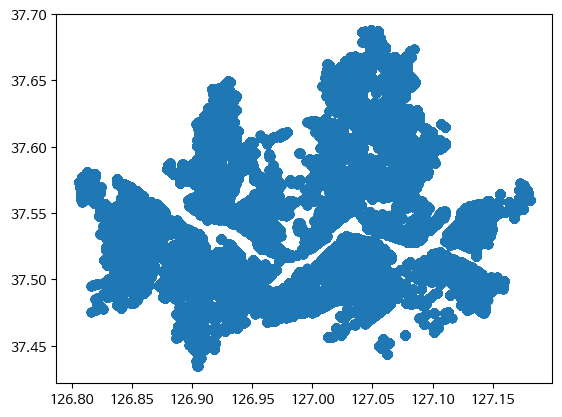

In [1747]:
plt.scatter(pre_df['좌표X'], pre_df['좌표Y'])

In [2974]:
pre_df = pd.read_csv("../data/dump/pre_df.csv")
concat = pd.read_csv("../data/dump/concat.csv")
y = pd.read_csv("../data/dump/y.csv")

/tmp/ipykernel_673659/3990387966.py:2: DtypeWarning: Columns (13,14,33) have mixed types. Specify dtype option on import or set low_memory=False.
  concat = pd.read_csv("../data/dump/concat.csv")


# 시군구

In [2975]:
pre_df.head()

,is_test,본번,부번,시군구,좌표Y,좌표X
0,0,658,1,서울특별시 강남구 개포동,37.476156,127.057212
1,0,658,1,서울특별시 강남구 개포동,37.476156,127.057212
2,0,658,1,서울특별시 강남구 개포동,37.476156,127.057212
3,0,658,1,서울특별시 강남구 개포동,37.476156,127.057212
4,0,658,1,서울특별시 강남구 개포동,37.476156,127.057212


In [2976]:
pre_df['시'] = pre_df['시군구'].str.split(' ', expand=True)[0]
pre_df['구'] = pre_df['시군구'].str.split(' ', expand=True)[1]
pre_df['동'] = pre_df['시군구'].str.split(' ', expand=True)[2]

In [2977]:
pre_df.drop(columns=['시군구'], axis=1 , inplace=True)
concat.drop(columns=['시군구'], axis=1 , inplace=True)

## 시

In [2978]:
pre_df['시'].value_counts()

서울특별시    1128019
Name: 시, dtype: int64

In [2979]:
pre_df.drop(columns=['시'], axis=1, inplace=True)

## 구

In [2980]:
pre_df['구'].isnull().sum()

0

In [2981]:
pre_df['구'].value_counts()

노원구     115837
송파구      74444
강남구      69656
강서구      67041
강동구      62425
구로구      57983
성북구      57160
양천구      54441
서초구      53478
도봉구      52872
영등포구     48097
동작구      40867
마포구      40810
동대문구     40068
성동구      39831
은평구      38664
중랑구      37303
관악구      36243
서대문구     33272
광진구      22252
강북구      22137
용산구      20682
금천구      19738
중구       13534
종로구       9184
Name: 구, dtype: int64

In [2982]:
pre_df = pd.concat([pre_df, pd.get_dummies(pre_df['구'])], axis=1)

In [2983]:
pre_df.drop(columns=['구'], axis=1, inplace=True)

## 동

In [2984]:
pre_df['동'].isnull().sum()

0

In [2985]:
pre_df['동'].value_counts()

상계동     45232
중계동     26524
신정동     24240
창동      23222
구로동     22941
        ...  
필동1가        6
주성동         5
연지동         4
입정동         3
구수동         3
Name: 동, Length: 337, dtype: int64

In [2986]:
pre_df['동'].apply(lambda x: re.split(r'\d', x, maxsplit=1)[0]).value_counts()

상계동    45232
중계동    26524
신정동    24240
창동     23222
구로동    22941
       ...  
누상동        8
주성동        5
연지동        4
입정동        3
구수동        3
Name: 동, Length: 279, dtype: int64

In [2987]:
pre_df['동'] = pre_df['동'].apply(lambda x: re.split(r'\d', x, maxsplit=1)[0])

In [2988]:
value_counts = pre_df['동'].value_counts()
pre_df['빈도수_동'] = pre_df['동'].map(value_counts)

le = LabelEncoder()
pre_df['le_동'] = le.fit_transform(pre_df['동'])

tmp = pre_df.query('is_test==0')
tmp['y'] = y

print(pearsonr(tmp['빈도수_동'], tmp['y']))
print(pearsonr(tmp['le_동'], tmp['y']))

PearsonRResult(statistic=-0.1570008475900332, pvalue=0.0)
PearsonRResult(statistic=0.00309354441085033, pvalue=0.0010676238571287273)


/tmp/ipykernel_673659/157625362.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


In [2989]:
pre_df['동'] = pre_df['빈도수_동']

pre_df.drop(columns=['빈도수_동', 'le_동'], axis=1, inplace=True)

In [2990]:
pre_df.head()

,is_test,본번,부번,좌표Y,좌표X,동,강남구,강동구,강북구,강서구,...,성동구,성북구,송파구,양천구,영등포구,용산구,은평구,종로구,중구,중랑구
0,0,658,1,37.476156,127.057212,12309,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,658,1,37.476156,127.057212,12309,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,658,1,37.476156,127.057212,12309,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,658,1,37.476156,127.057212,12309,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,658,1,37.476156,127.057212,12309,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 아파트명

In [2991]:
concat['아파트명'].isnull().sum()

2136

In [2992]:
# train nan : 2126, test nan : 10
concat.query('is_test==0')['아파트명'].isnull().sum()

2126

In [2993]:
tmp_0 = concat.query('is_test==0')
tmp_1 = concat.query('is_test==1')

In [2994]:
nan_index = tmp_0[tmp_0['아파트명'].isnull()].index

In [2995]:
tmp_0.drop(nan_index, inplace=True)
tmp_0.reset_index(inplace=True, drop=True)

concat = pd.concat([tmp_0, tmp_1]) 
concat.reset_index(inplace=True, drop=True)

y.drop(nan_index, inplace=True)
y.reset_index(inplace=True, drop=True)

pre_df.drop(nan_index, inplace=True)
pre_df.reset_index(inplace=True, drop=True)

/tmp/ipykernel_673659/3017390333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_0.drop(nan_index, inplace=True)


In [2996]:
len(concat), len(pre_df), len(concat.query('is_test==0')), len(pre_df.query('is_test==0')), len(y)

(1125893, 1125893, 1116621, 1116621, 1116621)

In [2997]:
concat['아파트명'].isnull().sum()

10

In [2998]:
pre_df['아파트명'] = concat['아파트명']

In [2999]:
nan_index = pre_df[pre_df['아파트명'].isna()].index

In [3000]:
pre_df.iloc[nan_index]

,is_test,본번,부번,좌표Y,좌표X,동,강남구,강동구,강북구,강서구,...,성북구,송파구,양천구,영등포구,용산구,은평구,종로구,중구,중랑구,아파트명
1119072,1,740,7,37.488786,126.886504,22941,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1119073,1,743,27,37.488947,126.887178,22941,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1119074,1,747,34,37.486943,126.886823,22941,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1119075,1,752,17,37.488452,126.888092,22941,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1119076,1,780,86,37.486882,126.888783,22941,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1120656,1,404,13,37.564500,127.062563,10203,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1121070,1,323,4,37.498830,126.929687,10967,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1124662,1,1101,1,37.486919,126.900555,5555,0,0,0,0,...,0,0,0,1,0,0,0,0,0,NaN
1124663,1,1101,1,37.486919,126.900555,5555,0,0,0,0,...,0,0,0,1,0,0,0,0,0,NaN
1125587,1,432,904,37.551392,127.005965,8231,0,0,0,0,...,0,0,0,0,0,0,0,1,0,NaN


In [3001]:
pre_df['아파트명'] = pre_df['아파트명'].ffill()

In [3002]:
len(pre_df['아파트명'].value_counts())

6548

In [3003]:
pre_df['아파트명'] = pre_df['아파트명'].str.split(' ', expand=True)[0]

In [3004]:
pre_df['아파트명'] = pre_df['아파트명'].str.replace(r'\d', '', regex=True)
pre_df['아파트명'] = pre_df['아파트명'].str.replace(r'[A-Z]동', '', regex=True)  # A동 ~ Z동 제거
pre_df['아파트명'] = pre_df['아파트명'].str.replace(r'뷰$', '', regex=True)  # '뷰'로 끝나는 문자열 제거
pre_df['아파트명'].value_counts()

상계주공           24239
현대             24138
주공             22365
목동신시가지         15669
신동아            14321
               ...  
비버리캐슬              1
브이티스타일             1
한원힐트리움아레나          1
힐스테이트홍은포레스트        1
DK밸리뷰서초차           1
Name: 아파트명, Length: 5663, dtype: int64

In [3005]:
value_counts = pre_df['아파트명'].value_counts()
pre_df['빈도수_아파트명'] = pre_df['아파트명'].map(value_counts)

le = LabelEncoder()
pre_df['le_아파트명'] = le.fit_transform(pre_df['아파트명'])

tmp = pre_df.query('is_test==0')
tmp['y'] = y

print(pearsonr(tmp['빈도수_아파트명'], tmp['y']))
print(pearsonr(tmp['le_아파트명'], tmp['y']))

PearsonRResult(statistic=-0.07429432346927241, pvalue=0.0)
PearsonRResult(statistic=-0.02193577489854075, pvalue=6.859849198030036e-119)


/tmp/ipykernel_673659/587401346.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


In [3006]:
pre_df['아파트명'] = pre_df['빈도수_아파트명']

pre_df.drop(columns=['빈도수_아파트명', 'le_아파트명'], axis=1, inplace=True)

In [3007]:
concat.drop(columns=['아파트명'], axis=1, inplace = True)

# 전용면적

In [3008]:
concat['전용면적(㎡)'].isnull().sum()

0

In [3009]:
pre_df['전용면적'] = concat['전용면적(㎡)']

In [3010]:
concat.drop(columns=['전용면적(㎡)'], axis=1, inplace=True)

# 계약년월 + 계약일

In [3011]:
concat[['계약년월', '계약일']].isnull().sum()

계약년월    0
계약일     0
dtype: int64

In [3012]:
pre_df['계약_년'] = concat['계약년월'].astype('str').str.slice(0,4).astype('int')
pre_df['계약_월'] = concat['계약년월'].astype('str').str.slice(4,7).astype('int')
pre_df['계약_일'] = concat['계약일']

In [3013]:
concat.drop(columns=['계약년월', '계약일'], axis=1, inplace=True)

# 층

In [3014]:
len(concat[concat['층'] < 0])

259

In [3015]:
concat['층'].isnull().sum()

0

In [3016]:
pre_df['층'] = concat['층']

In [3017]:
tmp = pre_df.query('is_test==0')

In [3018]:
nan_index = tmp[tmp['층'] <= 0].index

In [3019]:
pre_df.drop(nan_index, inplace=True)
pre_df.reset_index(drop=True, inplace=True)

concat.drop(nan_index, inplace=True)
concat.reset_index(drop=True, inplace=True)

y.drop(nan_index, inplace=True)
y.reset_index(drop=True, inplace=True)

In [3020]:
len(pre_df), len(concat)

(1125637, 1125637)

In [3021]:
pre_df[pre_df['층'] <= 0]

,is_test,본번,부번,좌표Y,좌표X,동,강남구,강동구,강북구,강서구,...,은평구,종로구,중구,중랑구,아파트명,전용면적,계약_년,계약_월,계약_일,층
1124650,1,810,0,37.536973,127.009490,2704,0,0,0,0,...,0,0,0,0,711,240.305,2023,8,27,-1
1125181,1,84,0,37.636440,126.928783,8580,0,0,0,0,...,1,0,0,0,1256,101.490,2023,7,29,-3
1125397,1,432,1970,37.551122,127.005550,8231,0,0,0,0,...,0,0,1,0,13,29.400,2023,7,21,-1


In [3022]:
pre_df[(pre_df['좌표X'] == pre_df.loc[1124650, '좌표X']) & (pre_df['좌표Y'] == pre_df.loc[1124650, '좌표Y'])]['층'].value_counts()

 1     102
 3     100
 2      91
 5      79
 6      79
 4      77
 7      43
 8      40
 9      34
 10     34
 12      7
 11      6
-1       1
Name: 층, dtype: int64

In [3023]:
pre_df.loc[1124650, '층'] = 1

In [3024]:
pre_df[(pre_df['좌표X'] == pre_df.loc[1125181, '좌표X']) & (pre_df['좌표Y'] == pre_df.loc[1125181, '좌표Y'])]['층'].value_counts()

 3     37
 5     32
 2     27
 4     25
 9     21
 7     21
 8     17
 6     16
 10    16
 1     16
 12    13
 11     8
 15     6
 13     5
 14     4
-3      1
Name: 층, dtype: int64

In [3025]:
pre_df.loc[1125181, '층'] = 3

In [3026]:
pre_df[(pre_df['좌표X'] == pre_df.loc[1125397, '좌표X']) & (pre_df['좌표Y'] == pre_df.loc[1125397, '좌표Y'])]['층'].value_counts()

 1    4
 2    3
 4    1
-1    1
Name: 층, dtype: int64

In [3027]:
pre_df.loc[1125397, '층'] = 1

In [3028]:
len(pre_df[pre_df['층'] <= 0])

0

In [3029]:
concat.drop(columns=['층'], axis=1, inplace=True)

# 건축년도

In [3030]:
concat['건축년도'].isnull().sum()

0

In [3031]:
pre_df['건축년도'] = concat['건축년도']

In [3032]:
concat.drop(columns=['건축년도'] , axis=1, inplace=True)

# 도로명

In [3033]:
concat['도로명'].isnull().sum()

0

In [3034]:
concat['도로명'] = concat['도로명'].str.split(' ', expand=True)[0]

In [3035]:
concat['도로명'].value_counts()

마들로         13255
올림픽로        12790
섬밭로         10442
해등로         10307
목동동로         9810
            ...  
청룡3길            1
반포대로9길          1
목동중앙북로4길        1
노원로19길          1
송정길             1
Name: 도로명, Length: 3601, dtype: int64

In [3036]:
concat['도로명'].str.replace(r'\d', '', regex=True).value_counts()

동일로길      23503
마들로       13255
올림픽로      12790
양천로길      10814
섬밭로       10442
          ...  
효창원로마길        2
수유로나길         1
사당로라길         1
경서로           1
송정길           1
Name: 도로명, Length: 1204, dtype: int64

In [3037]:
concat['도로명'].str.replace(r'\d+(가|나|다|라|마|바|사|아|자|차|카|타|파|하)?길', '', regex=True).value_counts()

동일로      35115
올림픽로     19757
덕릉로      17242
양천로      15821
한글비석로    15416
         ...  
비봉길          4
위례송파로        3
숭문           3
과천대로         2
송정길          1
Name: 도로명, Length: 578, dtype: int64

In [3038]:
concat['도로명'] = concat['도로명'].str.replace(r'\d+(가|나|다|라|마|바|사|아|자|차|카|타|파|하)?길', '', regex=True)
concat['도로명'].value_counts()

동일로      35115
올림픽로     19757
덕릉로      17242
양천로      15821
한글비석로    15416
         ...  
비봉길          4
위례송파로        3
숭문           3
과천대로         2
송정길          1
Name: 도로명, Length: 578, dtype: int64

In [3039]:
pre_df['도로명'] = concat['도로명']

In [3040]:
value_counts = pre_df['도로명'].value_counts()
pre_df['빈도수_도로명'] = pre_df['도로명'].map(value_counts)

le = LabelEncoder()
pre_df['le_도로명'] = le.fit_transform(pre_df['도로명'])

tmp = pre_df.query('is_test==0')
tmp['y'] = y

print(pearsonr(tmp['빈도수_도로명'], tmp['y']))
print(pearsonr(tmp['le_도로명'], tmp['y']))

PearsonRResult(statistic=-0.0679418046993382, pvalue=0.0)
PearsonRResult(statistic=0.035412530297873765, pvalue=1.3732109569754525e-306)


/tmp/ipykernel_673659/2929029893.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


In [3041]:
pre_df['도로명'] = pre_df['빈도수_도로명']

pre_df.drop(columns=['빈도수_도로명', 'le_도로명'], axis=1, inplace=True)

concat.drop(columns=['도로명'], axis=1, inplace=True)

# 해제사유발생일

In [3042]:
concat['해제사유발생일'].isnull().sum() / len(concat)

0.9945248779135725

In [3043]:
concat.drop(columns=['해제사유발생일'], axis=1, inplace=True)

# 등기신청일자

In [3044]:
concat['등기신청일자'].isnull().sum()

0

In [3045]:
concat['등기신청일자'].value_counts()

            1108853
20230630        584
20230831        496
20230428        393
20230731        374
             ...   
20230125          3
20230105          3
20230110          3
20230109          1
20230104          1
Name: 등기신청일자, Length: 181, dtype: int64

In [3046]:
concat['등기신청일자'] = concat['등기신청일자'].map(lambda x: np.NAN if x == ' ' else x)

In [3047]:
concat['등기신청일자'].isnull().sum() / len(concat)

0.9850893316406621

In [3048]:
concat.drop(columns=['등기신청일자'] , axis=1, inplace=True)

# 거래유형

In [3049]:
concat['거래유형'].isnull().sum()

0

In [3050]:
concat['거래유형'].value_counts()

-       1084161
중개거래      37999
직거래        3477
Name: 거래유형, dtype: int64

In [3051]:
concat['거래유형'] = concat['거래유형'].map(lambda x: np.NAN if x == '-' else x)

In [3052]:
concat['거래유형'].isnull().sum() / len(concat)

0.9631533078603493

In [3053]:
concat.drop(columns=['거래유형'] , axis=1, inplace=True)

# 중개사소재지

In [3054]:
concat['중개사소재지'].value_counts()

-                  1087680
서울 노원구                2627
서울 송파구                2538
서울 강남구                2506
서울 강동구                2038
                    ...   
서울 송파구, 인천 계양구           1
경기 연천군, 서울 송파구           1
부산 해운대구, 서울 송파구          1
경기 김포시, 서울 송파구           1
서울 중랑구, 인천 부평구           1
Name: 중개사소재지, Length: 737, dtype: int64

In [3055]:
concat['중개사소재지'] = concat['중개사소재지'].map(lambda x: np.NAN if x == '-' else x)

In [3056]:
concat['중개사소재지'].isnull().sum() / len(concat)

0.9662795377195312

In [3057]:
concat.drop(columns=['중개사소재지'], axis=1, inplace=True)

# k-단지분류(아파트,주상복합등등)

In [3058]:
concat['k-단지분류(아파트,주상복합등등)'].isnull().sum() / len(concat)

0.7772025972849151

In [3059]:
concat['k-단지분류(아파트,주상복합등등)'].value_counts()

아파트               238554
주상복합               11450
도시형 생활주택(주상복합)       505
도시형 생활주택(아파트)        155
연립주택                 125
Name: k-단지분류(아파트,주상복합등등), dtype: int64

In [3060]:
pre_df['단지분류'] = concat['k-단지분류(아파트,주상복합등등)']

In [3061]:
pre_df['단지분류'].isnull().sum()

874848

In [3062]:
# 그룹화하여 동일한 좌표의 단지분류 값을 확인
def fill_missing_by_group(group):
    # 단지분류가 비어 있지 않은 값 가져오기
    non_null_values = group['단지분류'].dropna().unique()
    if len(non_null_values) > 0:  # 채울 값이 있는 경우
        group['단지분류'] = non_null_values[0]  # 첫 번째 값을 사용
    return group

pre_df = pre_df.groupby(['좌표X', '좌표Y']).apply(fill_missing_by_group)
pre_df['단지분류'].isnull().sum()

/tmp/ipykernel_673659/1027286490.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pre_df = pre_df.groupby(['좌표X', '좌표Y']).apply(fill_missing_by_group)


873240

In [3063]:
pre_df['단지분류'].isnull().sum() / len(pre_df)

0.7757740728138822

In [3064]:
pre_df['단지분류'].value_counts()

아파트               240162
주상복합               11450
도시형 생활주택(주상복합)       505
도시형 생활주택(아파트)        155
연립주택                 125
Name: 단지분류, dtype: int64

In [3065]:
pre_df['단지분류'].str.split(expand=True)[0].value_counts()

아파트     240162
주상복합     11450
도시형        660
연립주택       125
Name: 0, dtype: int64

In [3066]:
pre_df['단지분류'] = pre_df['단지분류'].fillna('미정')

In [3067]:
pre_df['단지분류'].value_counts()

미정                873240
아파트               240162
주상복합               11450
도시형 생활주택(주상복합)       505
도시형 생활주택(아파트)        155
연립주택                 125
Name: 단지분류, dtype: int64

In [3068]:
value_counts = pre_df['단지분류'].value_counts()
pre_df['빈도수_단지분류'] = pre_df['단지분류'].map(value_counts)

le = LabelEncoder()
pre_df['le_단지분류'] = le.fit_transform(pre_df['단지분류'])

tmp = pre_df.query('is_test==0')
tmp['y'] = y

print(pearsonr(tmp['빈도수_단지분류'], tmp['y']))
print(pearsonr(tmp['le_단지분류'], tmp['y']))

PearsonRResult(statistic=-0.11841741575324871, pvalue=0.0)
PearsonRResult(statistic=0.11010324717430199, pvalue=0.0)


/tmp/ipykernel_673659/1741501637.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


In [3069]:
pre_df['단지분류'] = pre_df['빈도수_단지분류']

pre_df.drop(columns=['빈도수_단지분류', 'le_단지분류'], axis=1, inplace=True)
concat.drop(columns=['k-단지분류(아파트,주상복합등등)'], axis=1, inplace=True)

In [3070]:
pre_df['단지분류'].isnull().sum()

0

# k-전화번호

In [3071]:
concat.drop(columns=['k-전화번호'], axis=1, inplace=True)

# k-팩스번호

In [3072]:
concat.drop(columns=['k-팩스번호'], axis=1, inplace=True)

# 단지소개기존clob

In [3073]:
concat['단지소개기존clob'].isnull().sum() / len(concat)

0.9385849967618335

In [3074]:
concat.drop(columns=['단지소개기존clob'], axis=1, inplace=True)

# k-세대타입(분양형태)

In [3075]:
concat['k-세대타입(분양형태)'].isnull().sum() / len(concat)

0.7761827303118145

In [3076]:
concat['k-세대타입(분양형태)'].value_counts()

분양    208079
기타     41625
임대      2233
Name: k-세대타입(분양형태), dtype: int64

In [3077]:
pre_df['분양형태'] = concat['k-세대타입(분양형태)']

In [3078]:
pre_df['분양형태'] = pre_df['분양형태'].fillna('미정')

In [3079]:
pre_df['분양형태'].value_counts()

미정    873700
분양    208079
기타     41625
임대      2233
Name: 분양형태, dtype: int64

In [3080]:
value_counts = pre_df['분양형태'].value_counts()
pre_df['빈도수_분양형태'] = pre_df['분양형태'].map(value_counts)

le = LabelEncoder()
pre_df['le_분양형태'] = le.fit_transform(pre_df['분양형태'])

tmp = pre_df.query('is_test==0')
tmp['y'] = y

print(pearsonr(tmp['빈도수_분양형태'], tmp['y']))
print(pearsonr(tmp['le_분양형태'], tmp['y']))

PearsonRResult(statistic=-0.13111814999981325, pvalue=0.0)
PearsonRResult(statistic=-0.024199834566410693, pvalue=3.0613471992600526e-144)


/tmp/ipykernel_673659/832767505.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


In [3081]:
pre_df['분양형태'] = pre_df['빈도수_분양형태']

pre_df.drop(columns=['빈도수_분양형태', 'le_분양형태'], axis=1, inplace=True)
concat.drop(columns=['k-세대타입(분양형태)'], axis=1, inplace=True)

# k-관리방식

In [3082]:
concat['k-관리방식'].isnull().sum() / len(concat)

0.7761827303118145

In [3083]:
concat['k-관리방식'].value_counts()

위탁관리    230329
자치관리     18144
직영        3464
Name: k-관리방식, dtype: int64

In [3084]:
pre_df['관리방식'] = concat['k-관리방식']

In [3085]:
# 그룹화하여 동일한 좌표의 단지분류 값을 확인
def fill_missing_by_group(group):
    # 단지분류가 비어 있지 않은 값 가져오기
    non_null_values = group['관리방식'].dropna().unique()
    if len(non_null_values) > 0:  # 채울 값이 있는 경우
        group['관리방식'] = non_null_values[0]  # 첫 번째 값을 사용
    return group

pre_df = pre_df.groupby(['좌표X', '좌표Y']).apply(fill_missing_by_group)

/tmp/ipykernel_673659/2950445045.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pre_df = pre_df.groupby(['좌표X', '좌표Y']).apply(fill_missing_by_group)


In [3086]:
pre_df['관리방식'].isnull().sum() / len(pre_df)

0.7747542058407817

In [3087]:
pre_df['관리방식'] = pre_df['관리방식'].fillna('미정')

In [3088]:
pre_df['관리방식'].value_counts()

미정      872092
위탁관리    231850
자치관리     18231
직영        3464
Name: 관리방식, dtype: int64

In [3089]:
value_counts = pre_df['관리방식'].value_counts()
pre_df['빈도수_관리방식'] = pre_df['관리방식'].map(value_counts)

le = LabelEncoder()
pre_df['le_관리방식'] = le.fit_transform(pre_df['관리방식'])   

tmp = pre_df.query('is_test==0')
tmp['y'] = y

print(pearsonr(tmp['빈도수_관리방식'], tmp['y']))
print(pearsonr(tmp['le_관리방식'], tmp['y']))

PearsonRResult(statistic=-0.12222838103695553, pvalue=0.0)
PearsonRResult(statistic=0.12110190850405597, pvalue=0.0)


/tmp/ipykernel_673659/3776330431.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


In [3090]:
pre_df['관리방식'] = pre_df['빈도수_관리방식']

pre_df.drop(columns=['빈도수_관리방식', 'le_관리방식'], axis=1, inplace=True)
concat.drop(columns=['k-관리방식'], axis=1, inplace=True)

# k-복도유형

In [3091]:
concat['k-복도유형'].isnull().sum() / len(concat)

0.7764750092614227

In [3092]:
concat['k-복도유형'].value_counts()

계단식    124940
혼합식     85505
복도식     38710
타워형      1371
기타       1082
Name: k-복도유형, dtype: int64

In [3093]:
pre_df['복도유형'] = concat['k-복도유형']

In [3094]:
# 그룹화하여 동일한 좌표의 단지분류 값을 확인
def fill_missing_by_group(group):
    # 단지분류가 비어 있지 않은 값 가져오기
    non_null_values = group['복도유형'].dropna().unique()
    if len(non_null_values) > 0:  # 채울 값이 있는 경우
        group['복도유형'] = non_null_values[0]  # 첫 번째 값을 사용
    return group

pre_df = pre_df.groupby(['좌표X', '좌표Y']).apply(fill_missing_by_group)

/tmp/ipykernel_673659/4044730807.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pre_df = pre_df.groupby(['좌표X', '좌표Y']).apply(fill_missing_by_group)


In [3095]:
pre_df['복도유형'].isnull().sum() / len(pre_df)

0.7750464847903898

In [3096]:
pre_df['복도유형'] = pre_df['복도유형'].fillna('미정')

In [3097]:
pre_df['복도유형'].value_counts()

미정     872421
계단식    126158
혼합식     85864
복도식     38711
타워형      1401
기타       1082
Name: 복도유형, dtype: int64

In [3098]:
value_counts = pre_df['복도유형'].value_counts()
pre_df['빈도수_복도유형'] = pre_df['복도유형'].map(value_counts)

le = LabelEncoder()
pre_df['le_복도유형'] = le.fit_transform(pre_df['복도유형'])   

tmp = pre_df.query('is_test==0')
tmp['y'] = y

print(pearsonr(tmp['빈도수_복도유형'], tmp['y']))
print(pearsonr(tmp['le_복도유형'], tmp['y']))

PearsonRResult(statistic=-0.11341166438719608, pvalue=0.0)
PearsonRResult(statistic=-0.11623703911263789, pvalue=0.0)


/tmp/ipykernel_673659/762706852.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


In [3099]:
pre_df['복도유형'] = pre_df['le_복도유형']

pre_df.drop(columns=['빈도수_복도유형', 'le_복도유형'], axis=1, inplace=True)
concat.drop(columns=['k-복도유형'], axis=1, inplace=True)

# k-난방방식

In [3100]:
concat['k-난방방식'].isnull().sum() / len(concat)

0.7761827303118145

In [3101]:
pre_df['난방방식'] = concat['k-난방방식']

In [3102]:
# 그룹화하여 동일한 좌표의 단지분류 값을 확인
def fill_missing_by_group(group):
    # 단지분류가 비어 있지 않은 값 가져오기
    non_null_values = group['난방방식'].dropna().unique()
    if len(non_null_values) > 0:  # 채울 값이 있는 경우
        group['난방방식'] = non_null_values[0]  # 첫 번째 값을 사용
    return group

pre_df = pre_df.groupby(['좌표X', '좌표Y']).apply(fill_missing_by_group)

/tmp/ipykernel_673659/2283019425.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pre_df = pre_df.groupby(['좌표X', '좌표Y']).apply(fill_missing_by_group)


In [3103]:
pre_df['난방방식'].isnull().sum() / len(pre_df)

0.7747542058407817

In [3104]:
pre_df['난방방식'].value_counts()

개별난방    153194
지역난방     85573
중앙난방     12687
기타        2091
Name: 난방방식, dtype: int64

In [3105]:
pre_df['난방방식'] = pre_df['난방방식'].fillna('미정')

In [3106]:
value_counts = pre_df['난방방식'].value_counts()
pre_df['빈도수_난방방식'] = pre_df['난방방식'].map(value_counts)

le = LabelEncoder()
pre_df['le_난방방식'] = le.fit_transform(pre_df['난방방식'])   

tmp = pre_df.query('is_test==0')
tmp['y'] = y

print(pearsonr(tmp['빈도수_난방방식'], tmp['y']))
print(pearsonr(tmp['le_난방방식'], tmp['y']))

PearsonRResult(statistic=-0.12464014953825002, pvalue=0.0)
PearsonRResult(statistic=0.09421090665162461, pvalue=0.0)


/tmp/ipykernel_673659/2651802015.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


In [3107]:
pre_df['난방방식'] = pre_df['빈도수_난방방식']

pre_df.drop(columns=['빈도수_난방방식', 'le_난방방식'], axis=1, inplace=True)
concat.drop(columns=['k-난방방식'], axis=1, inplace=True)

# k-전체동수

In [3108]:
concat['k-전체동수'].isnull().sum() / len(concat)

0.7771439638178205

In [3109]:
pre_df['전체동수'] = concat['k-전체동수']

In [3110]:
# 그룹화하여 동일한 좌표의 단지분류 값을 확인
def fill_missing_by_group(group):
    # 단지분류가 비어 있지 않은 값 가져오기
    non_null_values = group['전체동수'].dropna().unique()
    if len(non_null_values) > 0:  # 채울 값이 있는 경우
        group['전체동수'] = non_null_values[0]  # 첫 번째 값을 사용
    return group

pre_df = pre_df.groupby(['좌표X', '좌표Y']).apply(fill_missing_by_group)

/tmp/ipykernel_673659/3801945013.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pre_df = pre_df.groupby(['좌표X', '좌표Y']).apply(fill_missing_by_group)


In [3111]:
pre_df['전체동수'].isnull().sum() / len(pre_df)

0.7757154393467877

In [3112]:
pre_df[pre_df['전체동수'] <= 0]

,is_test,본번,부번,좌표Y,좌표X,동,강남구,강동구,강북구,강서구,...,계약_일,층,건축년도,도로명,단지분류,분양형태,관리방식,복도유형,난방방식,전체동수


In [3113]:
tmp = pre_df.query('is_test==0')
tmp['y'] = y


def calculate_pearson(df, method):
    corr, p_value = pearsonr(df['전체동수'], df['y'])
    return corr, p_value

# 1. 선형 보간 (linear interpolation)
df_linear = tmp.copy()
df_linear['전체동수'] = df_linear['전체동수'].interpolate(method='linear')

# 2. Forward fill (ffill)
df_ffill = tmp.copy()
df_ffill['전체동수'] = df_ffill['전체동수'].fillna(method='ffill')

# 3. Backward fill (bfill)
df_bfill = tmp.copy()
df_bfill['전체동수'] = df_bfill['전체동수'].fillna(method='bfill')

# 4. fillna 0
df_fillna = tmp.copy()
df_fillna['전체동수'] = df_fillna['전체동수'].fillna(0)

# 피어슨 상관계수 계산
results = {
    'Linear Interpolation': calculate_pearson(df_linear, 'linear'),
    'Forward Fill (ffill)': calculate_pearson(df_ffill, 'ffill'),
    'Backward Fill (bfill)': calculate_pearson(df_bfill, 'bfill'),
    'fillna (fillna)' : calculate_pearson(df_fillna, 'fillna')
}

# 결과 출력
for method, (corr, p_value) in results.items():
    print(f"{method}: Pearson Correlation = {corr:.4f}, P-value = {p_value:.4f}")

/tmp/ipykernel_673659/3455941176.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


Linear Interpolation: Pearson Correlation = 0.1155, P-value = 0.0000
Forward Fill (ffill): Pearson Correlation = 0.1063, P-value = 0.0000
Backward Fill (bfill): Pearson Correlation = 0.1089, P-value = 0.0000
fillna (fillna): Pearson Correlation = 0.1740, P-value = 0.0000


In [3114]:
pre_df['전체동수'] = pre_df['전체동수'].fillna(0)
pre_df['전체동수'].isnull().sum()

0

In [3115]:
concat.drop(columns=['k-전체동수'], axis=1, inplace=True)

# k-전체세대수

In [3116]:
concat['k-전체세대수'].isnull().sum() / len(concat)

0.7761827303118145

<Axes: >

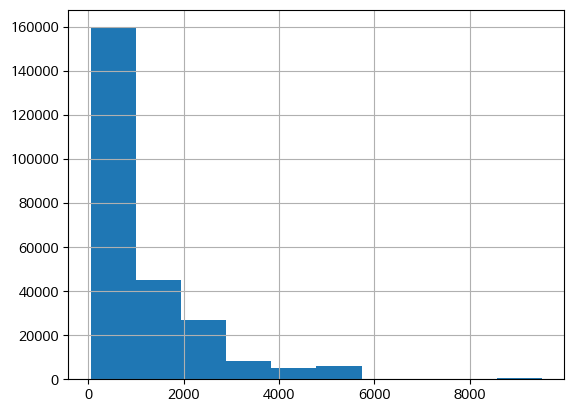

In [3117]:
concat['k-전체세대수'].hist()

In [3118]:
pre_df['전체세대수'] = concat['k-전체세대수']

In [3119]:
# 그룹화하여 동일한 좌표의 단지분류 값을 확인
def fill_missing_by_group(group):
    # 단지분류가 비어 있지 않은 값 가져오기
    non_null_values = group['전체세대수'].dropna().unique()
    if len(non_null_values) > 0:  # 채울 값이 있는 경우
        group['전체세대수'] = non_null_values[0]  # 첫 번째 값을 사용
    return group

pre_df = pre_df.groupby(['좌표X', '좌표Y']).apply(fill_missing_by_group)

/tmp/ipykernel_673659/255560621.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pre_df = pre_df.groupby(['좌표X', '좌표Y']).apply(fill_missing_by_group)


In [3120]:
pre_df['전체세대수'].isnull().sum() / len(pre_df)

0.7747542058407817

In [3121]:
tmp = pre_df.query('is_test==0')
tmp['y'] = y


def calculate_pearson(df, method):
    corr, p_value = pearsonr(df['전체세대수'], df['y'])
    return corr, p_value

# 1. 선형 보간 (linear interpolation)
df_linear = tmp.copy()
df_linear['전체세대수'] = df_linear['전체세대수'].interpolate(method='linear')

# 2. Forward fill (ffill)
df_ffill = tmp.copy()
df_ffill['전체세대수'] = df_ffill['전체세대수'].fillna(method='ffill')

# 3. Backward fill (bfill)
df_bfill = tmp.copy()
df_bfill['전체세대수'] = df_bfill['전체세대수'].fillna(method='bfill')

# 4. fillna 0
df_fillna = tmp.copy()
df_fillna['전체세대수'] = df_fillna['전체세대수'].fillna(0)

# 피어슨 상관계수 계산
results = {
    'Linear Interpolation': calculate_pearson(df_linear, 'linear'),
    'Forward Fill (ffill)': calculate_pearson(df_ffill, 'ffill'),
    'Backward Fill (bfill)': calculate_pearson(df_bfill, 'bfill'),
    'fillna (fillna)' : calculate_pearson(df_fillna, 'fillna')
}

# 결과 출력
for method, (corr, p_value) in results.items():
    print(f"{method}: Pearson Correlation = {corr:.4f}, P-value = {p_value:.4f}")

/tmp/ipykernel_673659/654649330.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


Linear Interpolation: Pearson Correlation = 0.1196, P-value = 0.0000
Forward Fill (ffill): Pearson Correlation = 0.1117, P-value = 0.0000
Backward Fill (bfill): Pearson Correlation = 0.1071, P-value = 0.0000
fillna (fillna): Pearson Correlation = 0.1690, P-value = 0.0000


In [3122]:
pre_df['전체세대수'] = pre_df['전체세대수'].fillna(0)
pre_df['전체세대수'].isnull().sum()

0

In [3123]:
concat.drop(columns=['k-전체세대수'], axis=1, inplace=True)

# k-건설사(시공사)

In [3124]:
concat['k-건설사(시공사)'].isnull().sum() / len(concat)

0.7775259697398007

In [3125]:
concat['k-건설사(시공사)'].value_counts()

삼성물산         14259
대우건설         11549
현대건설         10575
대한주택공사        7665
GS건설          7015
             ...  
두산               5
신영건설             3
자이에스앤디(주)        2
혜림건설             1
삼익건설(주)          1
Name: k-건설사(시공사), Length: 344, dtype: int64

In [3126]:
concat['k-건설사(시공사)'] = concat['k-건설사(시공사)'].str.split(' ', expand=True)[0]
concat['k-건설사(시공사)'].value_counts()

삼성물산         14505
대우건설         11549
현대건설         10575
대한주택공사        7665
GS건설          7015
             ...  
두산               5
신영건설             3
자이에스앤디(주)        2
혜림건설             1
삼익건설(주)          1
Name: k-건설사(시공사), Length: 332, dtype: int64

In [3127]:
concat['k-건설사(시공사)'] = concat['k-건설사(시공사)'].str.replace('\(주\)', '')
concat['k-건설사(시공사)'].value_counts()

/tmp/ipykernel_673659/3494475773.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  concat['k-건설사(시공사)'] = concat['k-건설사(시공사)'].str.replace('\(주\)', '')


삼성물산      19999
현대건설      16801
대우건설      15797
GS건설       8494
현대산업개발     7714
          ...  
한라건설         12
두산            5
신영건설          3
자이에스앤디        2
혜림건설          1
Name: k-건설사(시공사), Length: 261, dtype: int64

In [3128]:
pre_df['건설사(시공사)'] = concat['k-건설사(시공사)']

In [3129]:
# 그룹화하여 동일한 좌표의 단지분류 값을 확인
def fill_missing_by_group(group):
    # 단지분류가 비어 있지 않은 값 가져오기
    non_null_values = group['건설사(시공사)'].dropna().unique()
    if len(non_null_values) > 0:  # 채울 값이 있는 경우
        group['건설사(시공사)'] = non_null_values[0]  # 첫 번째 값을 사용
    return group

pre_df = pre_df.groupby(['좌표X', '좌표Y']).apply(fill_missing_by_group)

/tmp/ipykernel_673659/3855625345.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pre_df = pre_df.groupby(['좌표X', '좌표Y']).apply(fill_missing_by_group)


In [3130]:
pre_df['건설사(시공사)'].isnull().sum() / len(pre_df)

0.7760974452687678

In [3131]:
pre_df['건설사(시공사)'] = pre_df['건설사(시공사)'].fillna('미정')

In [3132]:
value_counts = pre_df['건설사(시공사)'].value_counts()
pre_df['빈도수_건설사(시공사)'] = pre_df['건설사(시공사)'].map(value_counts)

le = LabelEncoder()
pre_df['le_건설사(시공사)'] = le.fit_transform(pre_df['건설사(시공사)'])

tmp = pre_df.query('is_test==0')
tmp['y'] = y

print(pearsonr(tmp['빈도수_건설사(시공사)'], tmp['y']))
print(pearsonr(tmp['le_건설사(시공사)'], tmp['y']))

PearsonRResult(statistic=-0.11987076249592696, pvalue=0.0)
PearsonRResult(statistic=-0.002740935230025634, pvalue=0.0037792307935457154)


/tmp/ipykernel_673659/2693590716.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


In [3133]:
pre_df['건설사(시공사)'] = pre_df['빈도수_건설사(시공사)']

pre_df.drop(columns=['빈도수_건설사(시공사)', 'le_건설사(시공사)'], axis=1, inplace=True)

concat.drop(columns=['k-건설사(시공사)'], axis=1, inplace=True)

# k-시행사

In [3134]:
concat['k-시행사'].isnull().sum() / len(concat)

0.7777009817552195

In [3135]:
concat['k-시행사'].value_counts()

SH공사              12591
대한주택공사             7784
도시개발공사             4284
sh공사               4194
재건축조합              4065
                  ...  
(주)에스떠블유산업개발          2
청명종합건설(주)             2
사당3주택재건축정비사업조합        2
개포우성9차모델링조합           2
한호건설(주)               2
Name: k-시행사, Length: 556, dtype: int64

In [3136]:
concat['k-시행사'] = concat['k-시행사'].str.split(' ', expand=True)[0]

In [3137]:
concat['k-시행사'].value_counts()

SH공사              12591
대한주택공사             7784
서울시                5687
도시개발공사             4284
sh공사               4194
                  ...  
청명종합건설(주)             2
(주)에스떠블유산업개발          2
사당3주택재건축정비사업조합        2
개포우성9차모델링조합           2
한호건설(주)               2
Name: k-시행사, Length: 548, dtype: int64

In [3138]:
concat['k-시행사'] = concat['k-시행사'].str.replace('\(주\)', '')
concat['k-시행사'].value_counts()

/tmp/ipykernel_673659/2959314877.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  concat['k-시행사'] = concat['k-시행사'].str.replace('\(주\)', '')


SH공사              12591
대한주택공사             7784
서울시                5687
현대건설               4753
도시개발공사             4284
                  ...  
청명종합건설                2
에스떠블유산업개발             2
사당3주택재건축정비사업조합        2
개포우성9차모델링조합           2
한호건설                  2
Name: k-시행사, Length: 527, dtype: int64

In [3139]:
concat['k-시행사'] = concat['k-시행사'].str.replace(r'\d', '', regex=True)
concat['k-시행사'].value_counts()

SH공사             12591
대한주택공사            7784
서울시               5687
현대건설              4753
도시개발공사            4284
                 ...  
청명종합건설               2
에스떠블유산업개발            2
사당주택재건축정비사업조합        2
개포우성차모델링조합           2
한호건설                 2
Name: k-시행사, Length: 519, dtype: int64

In [3140]:
pre_df['시행사'] = concat['k-시행사']

In [3141]:
pre_df['시행사'] = pre_df['시행사'].fillna('미정')

In [3142]:
value_counts = pre_df['시행사'].value_counts()
pre_df['빈도수_시행사'] = pre_df['시행사'].map(value_counts)

le = LabelEncoder()
pre_df['le_시행사'] = le.fit_transform(pre_df['시행사'])

tmp = pre_df.query('is_test==0')
tmp['y'] = y

print(pearsonr(tmp['빈도수_시행사'], tmp['y']))
print(pearsonr(tmp['le_시행사'], tmp['y']))

PearsonRResult(statistic=-0.12023327753684886, pvalue=0.0)
PearsonRResult(statistic=0.05975097118510941, pvalue=0.0)


/tmp/ipykernel_673659/2062971187.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


In [3143]:
pre_df['시행사'] = pre_df['빈도수_시행사']

pre_df.drop(columns=['빈도수_시행사', 'le_시행사'], axis=1, inplace=True)

concat.drop(columns=['k-시행사'], axis=1, inplace=True)

# k-사용검사일-사용승인일

In [3144]:
concat['k-사용검사일-사용승인일'].isnull().sum() / len(concat)

0.7763017740177339

In [3145]:
concat['k-사용검사일-사용승인일'] = pd.to_datetime(concat['k-사용검사일-사용승인일'])

In [3146]:
pre_df['사용검사일_년'] = concat['k-사용검사일-사용승인일'].dt.year
pre_df['사용검사일_월'] = concat['k-사용검사일-사용승인일'].dt.month
pre_df['사용검사일_일'] = concat['k-사용검사일-사용승인일'].dt.day

In [3147]:
tmp = pre_df.query('is_test==0')
tmp['y'] = y


def calculate_pearson(df, method):
    corr, p_value = pearsonr(df['사용검사일_년'], df['y'])
    return corr, p_value

# 1. 선형 보간 (linear interpolation)
df_linear = tmp.copy()
df_linear['사용검사일_년'] = df_linear['사용검사일_년'].interpolate(method='linear')

# 2. Forward fill (ffill)
df_ffill = tmp.copy()
df_ffill['사용검사일_년'] = df_ffill['사용검사일_년'].fillna(method='ffill')

# 3. Backward fill (bfill)
df_bfill = tmp.copy()
df_bfill['사용검사일_년'] = df_bfill['사용검사일_년'].fillna(method='bfill')

# 4. fillna 0
df_fillna = tmp.copy()
df_fillna['사용검사일_년'] = df_fillna['사용검사일_년'].fillna(0)

# 피어슨 상관계수 계산
results = {
    'Linear Interpolation': calculate_pearson(df_linear, 'linear'),
    'Forward Fill (ffill)': calculate_pearson(df_ffill, 'ffill'),
    'Backward Fill (bfill)': calculate_pearson(df_bfill, 'bfill'),
    'fillna (fillna)' : calculate_pearson(df_fillna, 'fillna')
}

# 결과 출력
for method, (corr, p_value) in results.items():
    print(f"{method}: Pearson Correlation = {corr:.4f}, P-value = {p_value:.4f}")

/tmp/ipykernel_673659/1500290984.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


Linear Interpolation: Pearson Correlation = 0.1654, P-value = 0.0000
Forward Fill (ffill): Pearson Correlation = 0.1025, P-value = 0.0000
Backward Fill (bfill): Pearson Correlation = 0.1866, P-value = 0.0000
fillna (fillna): Pearson Correlation = 0.1205, P-value = 0.0000


In [3148]:
pre_df['사용검사일_년'] = pre_df['사용검사일_년'].bfill()
pre_df['사용검사일_년'].isnull().sum()

0

In [3149]:
tmp = pre_df.query('is_test==0')
tmp['y'] = y


def calculate_pearson(df, method):
    corr, p_value = pearsonr(df['사용검사일_월'], df['y'])
    return corr, p_value

# 1. 선형 보간 (linear interpolation)
df_linear = tmp.copy()
df_linear['사용검사일_월'] = df_linear['사용검사일_월'].interpolate(method='linear')

# 2. Forward fill (ffill)
df_ffill = tmp.copy()
df_ffill['사용검사일_월'] = df_ffill['사용검사일_월'].fillna(method='ffill')

# 3. Backward fill (bfill)
df_bfill = tmp.copy()
df_bfill['사용검사일_월'] = df_bfill['사용검사일_월'].fillna(method='bfill')

# 4. fillna 0
df_fillna = tmp.copy()
df_fillna['사용검사일_월'] = df_fillna['사용검사일_월'].fillna(0)

# 피어슨 상관계수 계산
results = {
    'Linear Interpolation': calculate_pearson(df_linear, 'linear'),
    'Forward Fill (ffill)': calculate_pearson(df_ffill, 'ffill'),
    'Backward Fill (bfill)': calculate_pearson(df_bfill, 'bfill'),
    'fillna (fillna)' : calculate_pearson(df_fillna, 'fillna')
}

# 결과 출력
for method, (corr, p_value) in results.items():
    print(f"{method}: Pearson Correlation = {corr:.4f}, P-value = {p_value:.4f}")

/tmp/ipykernel_673659/3763086991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


Linear Interpolation: Pearson Correlation = -0.0778, P-value = 0.0000
Forward Fill (ffill): Pearson Correlation = -0.0666, P-value = 0.0000
Backward Fill (bfill): Pearson Correlation = -0.0661, P-value = 0.0000
fillna (fillna): Pearson Correlation = 0.0842, P-value = 0.0000


In [3150]:
pre_df['사용검사일_월'] = pre_df['사용검사일_월'].fillna(0)
pre_df['사용검사일_월'].isnull().sum()

0

In [3151]:
tmp = pre_df.query('is_test==0')
tmp['y'] = y


def calculate_pearson(df, method):
    corr, p_value = pearsonr(df['사용검사일_일'], df['y'])
    return corr, p_value

# 1. 선형 보간 (linear interpolation)
df_linear = tmp.copy()
df_linear['사용검사일_일'] = df_linear['사용검사일_일'].interpolate(method='linear')

# 2. Forward fill (ffill)
df_ffill = tmp.copy()
df_ffill['사용검사일_일'] = df_ffill['사용검사일_일'].fillna(method='ffill')

# 3. Backward fill (bfill)
df_bfill = tmp.copy()
df_bfill['사용검사일_일'] = df_bfill['사용검사일_일'].fillna(method='bfill')

# 4. fillna 0
df_fillna = tmp.copy()
df_fillna['사용검사일_일'] = df_fillna['사용검사일_일'].fillna(0)

# 피어슨 상관계수 계산
results = {
    'Linear Interpolation': calculate_pearson(df_linear, 'linear'),
    'Forward Fill (ffill)': calculate_pearson(df_ffill, 'ffill'),
    'Backward Fill (bfill)': calculate_pearson(df_bfill, 'bfill'),
    'fillna (fillna)' : calculate_pearson(df_fillna, 'fillna')
}

# 결과 출력
for method, (corr, p_value) in results.items():
    print(f"{method}: Pearson Correlation = {corr:.4f}, P-value = {p_value:.4f}")

/tmp/ipykernel_673659/241048560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


Linear Interpolation: Pearson Correlation = -0.0188, P-value = 0.0000
Forward Fill (ffill): Pearson Correlation = 0.0325, P-value = 0.0000
Backward Fill (bfill): Pearson Correlation = -0.0565, P-value = 0.0000
fillna (fillna): Pearson Correlation = 0.1060, P-value = 0.0000


In [3152]:
pre_df['사용검사일_일'] = pre_df['사용검사일_일'].fillna(0)
pre_df['사용검사일_일'].isnull().sum()

0

In [3153]:
concat.drop(columns=['k-사용검사일-사용승인일'], axis=1, inplace=True)

# k-연면적

In [3154]:
concat['k-연면적'].isnull().sum() / len(concat)

0.7761827303118145

In [3155]:
concat[concat['k-연면적'] <= 0]['k-연면적'].value_counts()

0.0    1082
Name: k-연면적, dtype: int64

In [3156]:
nan_index = concat[concat['k-연면적'] <= 0].index

In [3157]:
concat.loc[nan_index, 'k-연면적'] = np.nan

In [3158]:
concat.loc[nan_index, 'k-연면적'].isnull().sum()

1082

In [3159]:
pre_df['연면적'] = concat['k-연면적']

In [3160]:
tmp = pre_df.query('is_test==0')
tmp['y'] = y


def calculate_pearson(df, method):
    corr, p_value = pearsonr(df['연면적'], df['y'])
    return corr, p_value

# 1. 선형 보간 (linear interpolation)
df_linear = tmp.copy()
df_linear['연면적'] = df_linear['연면적'].interpolate(method='linear')

# 2. Forward fill (ffill)
df_ffill = tmp.copy()
df_ffill['연면적'] = df_ffill['연면적'].fillna(method='ffill')

# 3. Backward fill (bfill)
df_bfill = tmp.copy()
df_bfill['연면적'] = df_bfill['연면적'].fillna(method='bfill')

# 4. fillna 0
df_fillna = tmp.copy()
df_fillna['연면적'] = df_fillna['연면적'].fillna(0)

# 피어슨 상관계수 계산
results = {
    'Linear Interpolation': calculate_pearson(df_linear, 'linear'),
    'Forward Fill (ffill)': calculate_pearson(df_ffill, 'ffill'),
    'Backward Fill (bfill)': calculate_pearson(df_bfill, 'bfill'),
    'fillna (fillna)' : calculate_pearson(df_fillna, 'fillna')
}

# 결과 출력
for method, (corr, p_value) in results.items():
    print(f"{method}: Pearson Correlation = {corr:.4f}, P-value = {p_value:.4f}")

/tmp/ipykernel_673659/98035644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


Linear Interpolation: Pearson Correlation = 0.2209, P-value = 0.0000
Forward Fill (ffill): Pearson Correlation = 0.2230, P-value = 0.0000
Backward Fill (bfill): Pearson Correlation = 0.1964, P-value = 0.0000
fillna (fillna): Pearson Correlation = 0.2218, P-value = 0.0000


In [3161]:
pre_df['연면적'] = pre_df['연면적'].ffill()
pre_df['연면적'].isnull().sum()

0

In [3162]:
concat.drop(columns=['k-연면적'], axis=1, inplace=True)

# k-주거전용면적

In [3163]:
concat['k-주거전용면적'].isnull().sum() / len(concat)

0.7762227076757428

In [3164]:
concat[concat['k-주거전용면적'] <= 0]['k-주거전용면적'].value_counts()

Series([], Name: k-주거전용면적, dtype: int64)

In [3165]:
pre_df['주거전용면적'] = concat['k-주거전용면적']

In [3166]:
tmp = pre_df.query('is_test==0')
tmp['y'] = y


def calculate_pearson(df, method):
    corr, p_value = pearsonr(df['주거전용면적'], df['y'])
    return corr, p_value

# 1. 선형 보간 (linear interpolation)
df_linear = tmp.copy()
df_linear['주거전용면적'] = df_linear['주거전용면적'].interpolate(method='linear')

# 2. Forward fill (ffill)
df_ffill = tmp.copy()
df_ffill['주거전용면적'] = df_ffill['주거전용면적'].fillna(method='ffill')

# 3. Backward fill (bfill)
df_bfill = tmp.copy()
df_bfill['주거전용면적'] = df_bfill['주거전용면적'].fillna(method='bfill')

# 4. fillna 0
df_fillna = tmp.copy()
df_fillna['주거전용면적'] = df_fillna['주거전용면적'].fillna(0)

# 피어슨 상관계수 계산
results = {
    'Linear Interpolation': calculate_pearson(df_linear, 'linear'),
    'Forward Fill (ffill)': calculate_pearson(df_ffill, 'ffill'),
    'Backward Fill (bfill)': calculate_pearson(df_bfill, 'bfill'),
    'fillna (fillna)' : calculate_pearson(df_fillna, 'fillna')
}

# 결과 출력
for method, (corr, p_value) in results.items():
    print(f"{method}: Pearson Correlation = {corr:.4f}, P-value = {p_value:.4f}")

/tmp/ipykernel_673659/3567771943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


Linear Interpolation: Pearson Correlation = 0.2024, P-value = 0.0000
Forward Fill (ffill): Pearson Correlation = 0.2129, P-value = 0.0000
Backward Fill (bfill): Pearson Correlation = 0.1743, P-value = 0.0000
fillna (fillna): Pearson Correlation = 0.2172, P-value = 0.0000


In [3167]:
pre_df['주거전용면적'] = pre_df['주거전용면적'].fillna(0)
pre_df['주거전용면적'].isnull().sum()

0

In [3168]:
concat.drop(columns=['k-주거전용면적'], axis=1, inplace=True)

# k-관리비부과면적

In [3169]:
concat['k-관리비부과면적'].isnull().sum() / len(concat)

0.7761827303118145

In [3170]:
concat[concat['k-관리비부과면적'] <= 0]['k-관리비부과면적'].value_counts()

0.0    1082
Name: k-관리비부과면적, dtype: int64

In [3171]:
nan_index = concat[concat['k-관리비부과면적'] <= 0].index

In [3172]:
concat.loc[nan_index, 'k-관리비부과면적'] = np.nan

In [3173]:
pre_df['관리비부과면적'] = concat['k-관리비부과면적']

In [3174]:
tmp = pre_df.query('is_test==0')
tmp['y'] = y


def calculate_pearson(df, method):
    corr, p_value = pearsonr(df['관리비부과면적'], df['y'])
    return corr, p_value

# 1. 선형 보간 (linear interpolation)
df_linear = tmp.copy()
df_linear['관리비부과면적'] = df_linear['관리비부과면적'].interpolate(method='linear')

# 2. Forward fill (ffill)
df_ffill = tmp.copy()
df_ffill['관리비부과면적'] = df_ffill['관리비부과면적'].fillna(method='ffill')

# 3. Backward fill (bfill)
df_bfill = tmp.copy()
df_bfill['관리비부과면적'] = df_bfill['관리비부과면적'].fillna(method='bfill')

# 4. fillna 0
df_fillna = tmp.copy()
df_fillna['관리비부과면적'] = df_fillna['관리비부과면적'].fillna(0)

# 피어슨 상관계수 계산
results = {
    'Linear Interpolation': calculate_pearson(df_linear, 'linear'),
    'Forward Fill (ffill)': calculate_pearson(df_ffill, 'ffill'),
    'Backward Fill (bfill)': calculate_pearson(df_bfill, 'bfill'),
    'fillna (fillna)' : calculate_pearson(df_fillna, 'fillna')
}

# 결과 출력
for method, (corr, p_value) in results.items():
    print(f"{method}: Pearson Correlation = {corr:.4f}, P-value = {p_value:.4f}")

/tmp/ipykernel_673659/1995597562.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


Linear Interpolation: Pearson Correlation = 0.1989, P-value = 0.0000
Forward Fill (ffill): Pearson Correlation = 0.2136, P-value = 0.0000
Backward Fill (bfill): Pearson Correlation = 0.1649, P-value = 0.0000
fillna (fillna): Pearson Correlation = 0.2099, P-value = 0.0000


In [3175]:
pre_df['관리비부과면적'] = pre_df['관리비부과면적'].ffill()
pre_df['관리비부과면적'].isnull().sum()

0

In [3176]:
concat.drop(columns=['k-관리비부과면적'], axis=1, inplace=True)

# 전용면적별세대현황

In [3177]:
concat.rename(
    columns={
        'k-전용면적별세대현황(60㎡이하)' : '60이하',
        'k-전용면적별세대현황(60㎡~85㎡이하)' : '85이하',
        'k-85㎡~135㎡이하' : '135이하',
        'k-135㎡초과' : '135초과'
    }, inplace=True
)

In [3178]:
tmp_cols = ['60이하', '85이하','135이하', '135초과']
concat[tmp_cols].isnull().sum()

60이하      873745
85이하      873745
135이하     873745
135초과    1125308
dtype: int64

In [3179]:
pre_df['전용면적별세대현황합'] = (concat[tmp_cols] * [1,2,3,4]).sum(axis=1)

In [3180]:
pre_df['전용면적별세대현황합'].isnull().sum()

0

<Axes: >

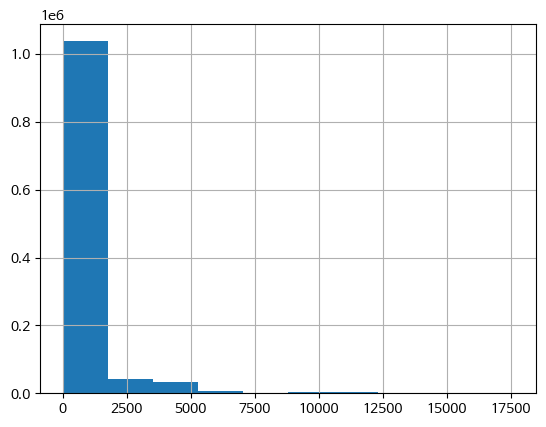

In [3181]:
pre_df['전용면적별세대현황합'].hist()

In [3182]:
concat.drop(columns=tmp_cols, axis=1, inplace=True)

# k-홈페이지

In [3183]:
concat['k-홈페이지'].isnull().sum() / len(concat)

0.8982167430530447

In [3184]:
concat.drop(columns=['k-홈페이지'], axis=1, inplace=True)

# k-등록일자

In [3185]:
concat['k-등록일자'].isnull().sum() / len(concat)

0.9895987782917584

In [3186]:
concat.drop(columns=['k-등록일자'], axis=1, inplace=True)

# k-수정일자

In [3187]:
concat['k-수정일자'].isnull().sum() / len(concat)

0.7762227076757428

In [3188]:
concat['k-수정일자'] = pd.to_datetime(concat['k-수정일자'])

In [3189]:
pre_df['수정일자_년'] = concat['k-수정일자'].dt.year
pre_df['수정일자_월'] = concat['k-수정일자'].dt.month
pre_df['수정일자_일'] = concat['k-수정일자'].dt.day

In [3190]:
pre_df['수정일자_년'].value_counts()

2023.0    247742
2020.0      3736
2021.0       414
Name: 수정일자_년, dtype: int64

In [3191]:
pre_df['수정일자_월'].value_counts()

/opt/conda/lib/python3.10/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


9.0    247523
2.0      3955
3.0       414
Name: 수정일자_월, dtype: int64

In [3192]:
pre_df['수정일자_일'].value_counts()

25.0    87106
26.0    56865
23.0    55370
24.0    25645
20.0    20718
17.0     3736
21.0     2038
30.0      414
Name: 수정일자_일, dtype: int64

In [3193]:
tmp = pre_df.query('is_test==0')
tmp['y'] = y


def calculate_pearson(df, method):
    corr, p_value = pearsonr(df['수정일자_년'], df['y'])
    return corr, p_value

# 1. 선형 보간 (linear interpolation)
df_linear = tmp.copy()
df_linear['수정일자_년'] = df_linear['수정일자_년'].interpolate(method='linear')

# 2. Forward fill (ffill)
df_ffill = tmp.copy()
df_ffill['수정일자_년'] = df_ffill['수정일자_년'].fillna(method='ffill')

# 3. Backward fill (bfill)
df_bfill = tmp.copy()
df_bfill['수정일자_년'] = df_bfill['수정일자_년'].fillna(method='bfill')

# 4. fillna 0
df_fillna = tmp.copy()
df_fillna['수정일자_년'] = df_fillna['수정일자_년'].fillna(0)

# 피어슨 상관계수 계산
results = {
    'Linear Interpolation': calculate_pearson(df_linear, 'linear'),
    'Forward Fill (ffill)': calculate_pearson(df_ffill, 'ffill'),
    'Backward Fill (bfill)': calculate_pearson(df_bfill, 'bfill'),
    'fillna (fillna)' : calculate_pearson(df_fillna, 'fillna')
}

# 결과 출력
for method, (corr, p_value) in results.items():
    print(f"{method}: Pearson Correlation = {corr:.4f}, P-value = {p_value:.4f}")

/tmp/ipykernel_673659/4282175856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


Linear Interpolation: Pearson Correlation = -0.0040, P-value = 0.0000
Forward Fill (ffill): Pearson Correlation = 0.0133, P-value = 0.0000
Backward Fill (bfill): Pearson Correlation = -0.0215, P-value = 0.0000
fillna (fillna): Pearson Correlation = 0.1198, P-value = 0.0000


In [3194]:
pre_df['수정일자_년'] = pre_df['수정일자_년'].fillna(0)
pre_df['수정일자_년'].isnull().sum()

0

In [3195]:
tmp = pre_df.query('is_test==0')
tmp['y'] = y


def calculate_pearson(df, method):
    corr, p_value = pearsonr(df['수정일자_월'], df['y'])
    return corr, p_value

# 1. 선형 보간 (linear interpolation)
df_linear = tmp.copy()
df_linear['수정일자_월'] = df_linear['수정일자_월'].interpolate(method='linear')

# 2. Forward fill (ffill)
df_ffill = tmp.copy()
df_ffill['수정일자_월'] = df_ffill['수정일자_월'].fillna(method='ffill')

# 3. Backward fill (bfill)
df_bfill = tmp.copy()
df_bfill['수정일자_월'] = df_bfill['수정일자_월'].fillna(method='bfill')

# 4. fillna 0
df_fillna = tmp.copy()
df_fillna['수정일자_월'] = df_fillna['수정일자_월'].fillna(0)

# 피어슨 상관계수 계산
results = {
    'Linear Interpolation': calculate_pearson(df_linear, 'linear'),
    'Forward Fill (ffill)': calculate_pearson(df_ffill, 'ffill'),
    'Backward Fill (bfill)': calculate_pearson(df_bfill, 'bfill'),
    'fillna (fillna)' : calculate_pearson(df_fillna, 'fillna')
}

# 결과 출력
for method, (corr, p_value) in results.items():
    print(f"{method}: Pearson Correlation = {corr:.4f}, P-value = {p_value:.4f}")

/tmp/ipykernel_673659/2970824261.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


Linear Interpolation: Pearson Correlation = -0.0044, P-value = 0.0000
Forward Fill (ffill): Pearson Correlation = 0.0128, P-value = 0.0000
Backward Fill (bfill): Pearson Correlation = -0.0217, P-value = 0.0000
fillna (fillna): Pearson Correlation = 0.1153, P-value = 0.0000


In [3196]:
pre_df['수정일자_월'] = pre_df['수정일자_월'].fillna(0)
pre_df['수정일자_월'].isnull().sum()

0

In [3197]:
tmp = pre_df.query('is_test==0')
tmp['y'] = y


def calculate_pearson(df, method):
    corr, p_value = pearsonr(df['수정일자_일'], df['y'])
    return corr, p_value

# 1. 선형 보간 (linear interpolation)
df_linear = tmp.copy()
df_linear['수정일자_일'] = df_linear['수정일자_일'].interpolate(method='linear')

# 2. Forward fill (ffill)
df_ffill = tmp.copy()
df_ffill['수정일자_일'] = df_ffill['수정일자_일'].fillna(method='ffill')

# 3. Backward fill (bfill)
df_bfill = tmp.copy()
df_bfill['수정일자_일'] = df_bfill['수정일자_일'].fillna(method='bfill')

# 4. fillna 0
df_fillna = tmp.copy()
df_fillna['수정일자_일'] = df_fillna['수정일자_일'].fillna(0)

# 피어슨 상관계수 계산
results = {
    'Linear Interpolation': calculate_pearson(df_linear, 'linear'),
    'Forward Fill (ffill)': calculate_pearson(df_ffill, 'ffill'),
    'Backward Fill (bfill)': calculate_pearson(df_bfill, 'bfill'),
    'fillna (fillna)' : calculate_pearson(df_fillna, 'fillna')
}

# 결과 출력
for method, (corr, p_value) in results.items():
    print(f"{method}: Pearson Correlation = {corr:.4f}, P-value = {p_value:.4f}")

/tmp/ipykernel_673659/2438259889.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


Linear Interpolation: Pearson Correlation = -0.1971, P-value = 0.0000
Forward Fill (ffill): Pearson Correlation = -0.1800, P-value = 0.0000
Backward Fill (bfill): Pearson Correlation = -0.1973, P-value = 0.0000
fillna (fillna): Pearson Correlation = 0.1076, P-value = 0.0000


In [3198]:
pre_df['수정일자_일'] = pre_df['수정일자_일'].bfill()
pre_df['수정일자_일'].isnull().sum()

0

In [3199]:
concat.drop(columns=['k-수정일자'], axis=1, inplace=True)

# 고용보험관리번호

In [3200]:
concat['고용보험관리번호'].isnull().sum() / len(concat)

0.8158331682416268

In [3201]:
concat.drop(columns=['고용보험관리번호'], axis=1, inplace=True)

# 경비비관리형태

In [3202]:
concat['경비비관리형태'].isnull().sum() / len(concat)

0.7774584524140553

In [3203]:
concat['경비비관리형태'].value_counts()

위탁       208725
직영        33791
위탁+직영      6168
기타         1817
Name: 경비비관리형태, dtype: int64

In [3204]:
pre_df['경비비관리형태'] = concat['경비비관리형태']

In [3205]:
pre_df['경비비관리형태'] = pre_df['경비비관리형태'].fillna('미정')

In [3206]:
value_counts = pre_df['경비비관리형태'].value_counts()
pre_df['빈도수_경비비관리형태'] = pre_df['경비비관리형태'].map(value_counts)

le = LabelEncoder()
pre_df['le_경비비관리형태'] = le.fit_transform(pre_df['경비비관리형태'])

tmp = pre_df.query('is_test==0')
tmp['y'] = y

print(pearsonr(tmp['빈도수_경비비관리형태'], tmp['y']))
print(pearsonr(tmp['le_경비비관리형태'], tmp['y']))

PearsonRResult(statistic=-0.11833081980405882, pvalue=0.0)
PearsonRResult(statistic=0.08705856181982738, pvalue=0.0)


/tmp/ipykernel_673659/219611535.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


In [3207]:
pre_df['경비비관리형태'] = pre_df['빈도수_경비비관리형태']

pre_df.drop(columns=['빈도수_경비비관리형태', 'le_경비비관리형태'], axis=1, inplace=True)

concat.drop(columns=['경비비관리형태'], axis=1, inplace=True)

# 세대전기계약방법

In [3208]:
concat['세대전기계약방법'].isnull().sum() / len(concat)

0.7844127369658247

In [3209]:
concat['세대전기계약방법'].value_counts()

종합계약    124583
단일계약    118090
Name: 세대전기계약방법, dtype: int64

In [3210]:
concat.drop(columns=['세대전기계약방법'] , axis=1, inplace=True)

# 청소비관리형태

In [3211]:
concat['청소비관리형태'].isnull().sum() / len(concat)

0.7776272457284187

In [3212]:
concat['청소비관리형태'].value_counts()

위탁       227479
직영        15174
위탁+직영      4179
기타         3479
Name: 청소비관리형태, dtype: int64

In [3213]:
concat.drop(columns=['청소비관리형태'], axis=1, inplace=True)

# 건축면적

In [3214]:
concat['건축면적'].isnull().sum() / len(concat)

0.7763195417350354

In [3215]:
pre_df['건축면적'] = concat['건축면적']

In [3216]:
tmp = pre_df.query('is_test==0')
tmp['y'] = y


def calculate_pearson(df, method):
    corr, p_value = pearsonr(df['건축면적'], df['y'])
    return corr, p_value

# 1. 선형 보간 (linear interpolation)
df_linear = tmp.copy()
df_linear['건축면적'] = df_linear['건축면적'].interpolate(method='linear')

# 2. Forward fill (ffill)
df_ffill = tmp.copy()
df_ffill['건축면적'] = df_ffill['건축면적'].fillna(method='ffill')

# 3. Backward fill (bfill)
df_bfill = tmp.copy()
df_bfill['건축면적'] = df_bfill['건축면적'].fillna(method='bfill')

# 4. fillna 0
df_fillna = tmp.copy()
df_fillna['건축면적'] = df_fillna['건축면적'].fillna(0)

# 피어슨 상관계수 계산
results = {
    'Linear Interpolation': calculate_pearson(df_linear, 'linear'),
    'Forward Fill (ffill)': calculate_pearson(df_ffill, 'ffill'),
    'Backward Fill (bfill)': calculate_pearson(df_bfill, 'bfill'),
    'fillna (fillna)' : calculate_pearson(df_fillna, 'fillna')
}

# 결과 출력
for method, (corr, p_value) in results.items():
    print(f"{method}: Pearson Correlation = {corr:.4f}, P-value = {p_value:.4f}")

/tmp/ipykernel_673659/1334877677.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


Linear Interpolation: Pearson Correlation = -0.0073, P-value = 0.0000
Forward Fill (ffill): Pearson Correlation = -0.0140, P-value = 0.0000
Backward Fill (bfill): Pearson Correlation = 0.0046, P-value = 0.0000
fillna (fillna): Pearson Correlation = 0.0259, P-value = 0.0000


In [3315]:
pre_df.drop(columns=['건축면적'] , axis=1, inplace=True)

In [3217]:
concat.drop(columns=['건축면적'] , axis=1, inplace=True)

# 주차대수

In [3218]:
concat['주차대수'].isnull().sum() / len(concat)

0.7763177649633052

In [3219]:
pre_df['주차대수'] = concat['주차대수']

In [3220]:
tmp = pre_df.query('is_test==0')
tmp['y'] = y


def calculate_pearson(df, method):
    corr, p_value = pearsonr(df['주차대수'], df['y'])
    return corr, p_value

# 1. 선형 보간 (linear interpolation)
df_linear = tmp.copy()
df_linear['주차대수'] = df_linear['주차대수'].interpolate(method='linear')

# 2. Forward fill (ffill)
df_ffill = tmp.copy()
df_ffill['주차대수'] = df_ffill['주차대수'].fillna(method='ffill')

# 3. Backward fill (bfill)
df_bfill = tmp.copy()
df_bfill['주차대수'] = df_bfill['주차대수'].fillna(method='bfill')

# 4. fillna 0
df_fillna = tmp.copy()
df_fillna['주차대수'] = df_fillna['주차대수'].fillna(0)

# 피어슨 상관계수 계산
results = {
    'Linear Interpolation': calculate_pearson(df_linear, 'linear'),
    'Forward Fill (ffill)': calculate_pearson(df_ffill, 'ffill'),
    'Backward Fill (bfill)': calculate_pearson(df_bfill, 'bfill'),
    'fillna (fillna)' : calculate_pearson(df_fillna, 'fillna')
}

# 결과 출력
for method, (corr, p_value) in results.items():
    print(f"{method}: Pearson Correlation = {corr:.4f}, P-value = {p_value:.4f}")

/tmp/ipykernel_673659/1113381248.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


Linear Interpolation: Pearson Correlation = 0.2022, P-value = 0.0000
Forward Fill (ffill): Pearson Correlation = 0.2153, P-value = 0.0000
Backward Fill (bfill): Pearson Correlation = 0.1673, P-value = 0.0000
fillna (fillna): Pearson Correlation = 0.2240, P-value = 0.0000


In [3221]:
pre_df['주차대수'] = pre_df['주차대수'].fillna(0)
pre_df['주차대수'].isnull().sum()

0

In [3222]:
concat.drop(columns=['주차대수'] , axis=1, inplace=True)

# 기타/의무/임대/임의

In [3223]:
concat['기타/의무/임대/임의=1/2/3/4'].isnull().sum()/ len(concat)

0.7761827303118145

In [3224]:
concat['기타/의무/임대/임의=1/2/3/4'].value_counts()

의무    241817
기타      4186
임의      3701
임대      2233
Name: 기타/의무/임대/임의=1/2/3/4, dtype: int64

In [3225]:
pre_df['기타/의무/임대/임의'] = concat['기타/의무/임대/임의=1/2/3/4'].fillna('미정')

In [3226]:
pre_df['기타/의무/임대/임의'].value_counts()

미정    873700
의무    241817
기타      4186
임의      3701
임대      2233
Name: 기타/의무/임대/임의, dtype: int64

In [3227]:
value_counts = pre_df['기타/의무/임대/임의'].value_counts()
pre_df['빈도수_기타/의무/임대/임의'] = pre_df['기타/의무/임대/임의'].map(value_counts)

le = LabelEncoder()
pre_df['le_기타/의무/임대/임의'] = le.fit_transform(pre_df['기타/의무/임대/임의'])

tmp = pre_df.query('is_test==0')
tmp['y'] = y

print(pearsonr(tmp['빈도수_기타/의무/임대/임의'], tmp['y']))
print(pearsonr(tmp['le_기타/의무/임대/임의'], tmp['y']))

PearsonRResult(statistic=-0.11993039875933532, pvalue=0.0)
PearsonRResult(statistic=0.10041095990302623, pvalue=0.0)


/tmp/ipykernel_673659/580443014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


In [3228]:
pre_df['기타/의무/임대/임의'] = pre_df['빈도수_기타/의무/임대/임의']

pre_df.drop(columns=['빈도수_기타/의무/임대/임의', 'le_기타/의무/임대/임의'], axis=1, inplace=True)

concat.drop(columns=['기타/의무/임대/임의=1/2/3/4'], axis=1, inplace=True)

# 단지승인일

In [3229]:
concat['단지승인일'].isnull().sum() / len(concat)

0.7768303636074507

In [3230]:
concat['단지승인일'] = pd.to_datetime(concat['단지승인일'])

In [3231]:
pre_df['단지승인일_년'] = concat['단지승인일'].dt.year
pre_df['단지승인일_월'] = concat['단지승인일'].dt.month
pre_df['단지승인일_일'] = concat['단지승인일'].dt.day

In [3232]:
tmp = pre_df.query('is_test==0')
tmp['y'] = y


def calculate_pearson(df, method):
    corr, p_value = pearsonr(df['단지승인일_년'], df['y'])
    return corr, p_value

# 1. 선형 보간 (linear interpolation)
df_linear = tmp.copy()
df_linear['단지승인일_년'] = df_linear['단지승인일_년'].interpolate(method='linear')

# 2. Forward fill (ffill)
df_ffill = tmp.copy()
df_ffill['단지승인일_년'] = df_ffill['단지승인일_년'].fillna(method='ffill')

# 3. Backward fill (bfill)
df_bfill = tmp.copy()
df_bfill['단지승인일_년'] = df_bfill['단지승인일_년'].fillna(method='bfill')

# 4. fillna 0
df_fillna = tmp.copy()
df_fillna['단지승인일_년'] = df_fillna['단지승인일_년'].fillna(0)

# 피어슨 상관계수 계산
results = {
    'Linear Interpolation': calculate_pearson(df_linear, 'linear'),
    'Forward Fill (ffill)': calculate_pearson(df_ffill, 'ffill'),
    'Backward Fill (bfill)': calculate_pearson(df_bfill, 'bfill'),
    'fillna (fillna)' : calculate_pearson(df_fillna, 'fillna')
}

# 결과 출력
for method, (corr, p_value) in results.items():
    print(f"{method}: Pearson Correlation = {corr:.4f}, P-value = {p_value:.4f}")

/tmp/ipykernel_673659/651114169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


Linear Interpolation: Pearson Correlation = 0.0130, P-value = 0.0000
Forward Fill (ffill): Pearson Correlation = 0.0188, P-value = 0.0000
Backward Fill (bfill): Pearson Correlation = 0.0066, P-value = 0.0000
fillna (fillna): Pearson Correlation = 0.1206, P-value = 0.0000


In [3233]:
pre_df['단지승인일_년'] = pre_df['단지승인일_년'].fillna(0)
pre_df['단지승인일_년'].isnull().sum()

0

In [3234]:
tmp = pre_df.query('is_test==0')
tmp['y'] = y


def calculate_pearson(df, method):
    corr, p_value = pearsonr(df['단지승인일_월'], df['y'])
    return corr, p_value

# 1. 선형 보간 (linear interpolation)
df_linear = tmp.copy()
df_linear['단지승인일_월'] = df_linear['단지승인일_월'].interpolate(method='linear')

# 2. Forward fill (ffill)
df_ffill = tmp.copy()
df_ffill['단지승인일_월'] = df_ffill['단지승인일_월'].fillna(method='ffill')

# 3. Backward fill (bfill)
df_bfill = tmp.copy()
df_bfill['단지승인일_월'] = df_bfill['단지승인일_월'].fillna(method='bfill')

# 4. fillna 0
df_fillna = tmp.copy()
df_fillna['단지승인일_월'] = df_fillna['단지승인일_월'].fillna(0)

# 피어슨 상관계수 계산
results = {
    'Linear Interpolation': calculate_pearson(df_linear, 'linear'),
    'Forward Fill (ffill)': calculate_pearson(df_ffill, 'ffill'),
    'Backward Fill (bfill)': calculate_pearson(df_bfill, 'bfill'),
    'fillna (fillna)' : calculate_pearson(df_fillna, 'fillna')
}

# 결과 출력
for method, (corr, p_value) in results.items():
    print(f"{method}: Pearson Correlation = {corr:.4f}, P-value = {p_value:.4f}")

/tmp/ipykernel_673659/185204749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


Linear Interpolation: Pearson Correlation = -0.0557, P-value = 0.0000
Forward Fill (ffill): Pearson Correlation = -0.0420, P-value = 0.0000
Backward Fill (bfill): Pearson Correlation = -0.0539, P-value = 0.0000
fillna (fillna): Pearson Correlation = 0.0838, P-value = 0.0000


In [3235]:
pre_df['단지승인일_월'] = pre_df['단지승인일_월'].fillna(0)
pre_df['단지승인일_월'].isnull().sum()

0

In [3236]:
tmp = pre_df.query('is_test==0')
tmp['y'] = y


def calculate_pearson(df, method):
    corr, p_value = pearsonr(df['단지승인일_일'], df['y'])
    return corr, p_value

# 1. 선형 보간 (linear interpolation)
df_linear = tmp.copy()
df_linear['단지승인일_일'] = df_linear['단지승인일_일'].interpolate(method='linear')

# 2. Forward fill (ffill)
df_ffill = tmp.copy()
df_ffill['단지승인일_일'] = df_ffill['단지승인일_일'].fillna(method='ffill')

# 3. Backward fill (bfill)
df_bfill = tmp.copy()
df_bfill['단지승인일_일'] = df_bfill['단지승인일_일'].fillna(method='bfill')

# 4. fillna 0
df_fillna = tmp.copy()
df_fillna['단지승인일_일'] = df_fillna['단지승인일_일'].fillna(0)

# 피어슨 상관계수 계산
results = {
    'Linear Interpolation': calculate_pearson(df_linear, 'linear'),
    'Forward Fill (ffill)': calculate_pearson(df_ffill, 'ffill'),
    'Backward Fill (bfill)': calculate_pearson(df_bfill, 'bfill'),
    'fillna (fillna)' : calculate_pearson(df_fillna, 'fillna')
}

# 결과 출력
for method, (corr, p_value) in results.items():
    print(f"{method}: Pearson Correlation = {corr:.4f}, P-value = {p_value:.4f}")

/tmp/ipykernel_673659/3589054337.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


Linear Interpolation: Pearson Correlation = 0.0502, P-value = 0.0000
Forward Fill (ffill): Pearson Correlation = 0.0384, P-value = 0.0000
Backward Fill (bfill): Pearson Correlation = 0.0357, P-value = 0.0000
fillna (fillna): Pearson Correlation = 0.1007, P-value = 0.0000


In [3237]:
pre_df['단지승인일_일'] = pre_df['단지승인일_일'].fillna(0)
pre_df['단지승인일_일'].isnull().sum()

0

In [3238]:
concat.drop(columns=['단지승인일'] , axis=1, inplace=True)

# 사용허가여부

In [3239]:
concat['사용허가여부'].isnull().sum() / len(concat)

0.7761827303118145

In [3240]:
concat['사용허가여부'].value_counts()

Y    251937
Name: 사용허가여부, dtype: int64

In [3241]:
pre_df['사용허가여부'] = concat['사용허가여부'].map(lambda x: 1 if x == 'Y' else 0)

In [3242]:
concat.drop(columns=['사용허가여부'] ,axis=1, inplace=True)

# 관리비 업로드

In [3243]:
concat['관리비 업로드'].isnull().sum() / len(concat)

0.7761827303118145

In [3244]:
concat['관리비 업로드'].value_counts()

N    247774
Y      4163
Name: 관리비 업로드, dtype: int64

In [3245]:
concat.drop(columns=['관리비 업로드'] , axis=1, inplace=True)

# 단지신청일

In [3250]:
concat['단지신청일'].isnull().sum() / len(concat)

0.7762378102354489

In [3252]:
concat['단지신청일'] = pd.to_datetime(concat['단지신청일'])

In [3253]:
pre_df['단지신청일_년'] = concat['단지신청일'].dt.year
pre_df['단지신청일_월'] = concat['단지신청일'].dt.month
pre_df['단지신청일_일'] = concat['단지신청일'].dt.day

In [3254]:
pre_df['단지신청일_년'].value_counts()

2013.0    224044
2015.0      7640
2017.0      5521
2014.0      4919
2016.0      2503
2020.0      2339
2019.0      2115
2018.0      1270
2021.0       847
2022.0       385
2023.0       292
Name: 단지신청일_년, dtype: int64

In [3255]:
pre_df['단지신청일_월'].value_counts()

3.0     223334
2.0       5593
1.0       3585
6.0       3535
11.0      2484
9.0       2417
7.0       2405
5.0       2367
8.0       1902
10.0      1711
4.0       1691
12.0       851
Name: 단지신청일_월, dtype: int64

In [3256]:
pre_df['단지신청일_일'].value_counts()

7.0     222649
1.0       3179
22.0      2255
10.0      2196
12.0      1994
11.0      1918
21.0      1767
27.0      1630
9.0       1132
17.0      1022
14.0       999
26.0       977
23.0       933
25.0       912
28.0       867
18.0       721
16.0       715
8.0        659
2.0        656
24.0       646
3.0        595
13.0       563
15.0       539
6.0        414
29.0       384
19.0       379
5.0        368
30.0       351
20.0       277
4.0        178
Name: 단지신청일_일, dtype: int64

In [3257]:
tmp = pre_df.query('is_test==0')
tmp['y'] = y


def calculate_pearson(df, method):
    corr, p_value = pearsonr(df['단지신청일_년'], df['y'])
    return corr, p_value

# 1. 선형 보간 (linear interpolation)
df_linear = tmp.copy()
df_linear['단지신청일_년'] = df_linear['단지신청일_년'].interpolate(method='linear')

# 2. Forward fill (ffill)
df_ffill = tmp.copy()
df_ffill['단지신청일_년'] = df_ffill['단지신청일_년'].fillna(method='ffill')

# 3. Backward fill (bfill)
df_bfill = tmp.copy()
df_bfill['단지신청일_년'] = df_bfill['단지신청일_년'].fillna(method='bfill')

# 4. fillna 0
df_fillna = tmp.copy()
df_fillna['단지신청일_년'] = df_fillna['단지신청일_년'].fillna(0)

# 피어슨 상관계수 계산
results = {
    'Linear Interpolation': calculate_pearson(df_linear, 'linear'),
    'Forward Fill (ffill)': calculate_pearson(df_ffill, 'ffill'),
    'Backward Fill (bfill)': calculate_pearson(df_bfill, 'bfill'),
    'fillna (fillna)' : calculate_pearson(df_fillna, 'fillna')
}

# 결과 출력
for method, (corr, p_value) in results.items():
    print(f"{method}: Pearson Correlation = {corr:.4f}, P-value = {p_value:.4f}")

/tmp/ipykernel_673659/1427519775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


Linear Interpolation: Pearson Correlation = 0.1265, P-value = 0.0000
Forward Fill (ffill): Pearson Correlation = 0.1198, P-value = 0.0000
Backward Fill (bfill): Pearson Correlation = 0.1038, P-value = 0.0000
fillna (fillna): Pearson Correlation = 0.1201, P-value = 0.0000


In [3258]:
pre_df['단지신청일_년'] = pre_df['단지신청일_년'].interpolate(method='linear')
pre_df['단지신청일_년'].isnull().sum()

0

In [3259]:
tmp = pre_df.query('is_test==0')
tmp['y'] = y


def calculate_pearson(df, method):
    corr, p_value = pearsonr(df['단지신청일_월'], df['y'])
    return corr, p_value

# 1. 선형 보간 (linear interpolation)
df_linear = tmp.copy()
df_linear['단지신청일_월'] = df_linear['단지신청일_월'].interpolate(method='linear')

# 2. Forward fill (ffill)
df_ffill = tmp.copy()
df_ffill['단지신청일_월'] = df_ffill['단지신청일_월'].fillna(method='ffill')

# 3. Backward fill (bfill)
df_bfill = tmp.copy()
df_bfill['단지신청일_월'] = df_bfill['단지신청일_월'].fillna(method='bfill')

# 4. fillna 0
df_fillna = tmp.copy()
df_fillna['단지신청일_월'] = df_fillna['단지신청일_월'].fillna(0)

# 피어슨 상관계수 계산
results = {
    'Linear Interpolation': calculate_pearson(df_linear, 'linear'),
    'Forward Fill (ffill)': calculate_pearson(df_ffill, 'ffill'),
    'Backward Fill (bfill)': calculate_pearson(df_bfill, 'bfill'),
    'fillna (fillna)' : calculate_pearson(df_fillna, 'fillna')
}

# 결과 출력
for method, (corr, p_value) in results.items():
    print(f"{method}: Pearson Correlation = {corr:.4f}, P-value = {p_value:.4f}")

/tmp/ipykernel_673659/1614922833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


Linear Interpolation: Pearson Correlation = 0.0825, P-value = 0.0000
Forward Fill (ffill): Pearson Correlation = 0.0864, P-value = 0.0000
Backward Fill (bfill): Pearson Correlation = 0.0577, P-value = 0.0000
fillna (fillna): Pearson Correlation = 0.1293, P-value = 0.0000


In [3260]:
pre_df['단지신청일_월'] = pre_df['단지신청일_월'].fillna(0)
pre_df['단지신청일_월'].isnull().sum()

0

In [3261]:
tmp = pre_df.query('is_test==0')
tmp['y'] = y


def calculate_pearson(df, method):
    corr, p_value = pearsonr(df['단지신청일_일'], df['y'])
    return corr, p_value

# 1. 선형 보간 (linear interpolation)
df_linear = tmp.copy()
df_linear['단지신청일_일'] = df_linear['단지신청일_일'].interpolate(method='linear')

# 2. Forward fill (ffill)
df_ffill = tmp.copy()
df_ffill['단지신청일_일'] = df_ffill['단지신청일_일'].fillna(method='ffill')

# 3. Backward fill (bfill)
df_bfill = tmp.copy()
df_bfill['단지신청일_일'] = df_bfill['단지신청일_일'].fillna(method='bfill')

# 4. fillna 0
df_fillna = tmp.copy()
df_fillna['단지신청일_일'] = df_fillna['단지신청일_일'].fillna(0)

# 피어슨 상관계수 계산
results = {
    'Linear Interpolation': calculate_pearson(df_linear, 'linear'),
    'Forward Fill (ffill)': calculate_pearson(df_ffill, 'ffill'),
    'Backward Fill (bfill)': calculate_pearson(df_bfill, 'bfill'),
    'fillna (fillna)' : calculate_pearson(df_fillna, 'fillna')
}

# 결과 출력
for method, (corr, p_value) in results.items():
    print(f"{method}: Pearson Correlation = {corr:.4f}, P-value = {p_value:.4f}")

/tmp/ipykernel_673659/4154583352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


Linear Interpolation: Pearson Correlation = 0.0821, P-value = 0.0000
Forward Fill (ffill): Pearson Correlation = 0.0420, P-value = 0.0000
Backward Fill (bfill): Pearson Correlation = 0.0958, P-value = 0.0000
fillna (fillna): Pearson Correlation = 0.1324, P-value = 0.0000


In [3262]:
pre_df['단지신청일_일'] = pre_df['단지신청일_일'].fillna(0)
pre_df['단지신청일_일'].isnull().sum()

0

In [3263]:
concat.drop(columns=['단지신청일'], axis=1, inplace=True)

# 지하철 데이터

In [81]:
from scipy.spatial.distance import cdist

In [82]:
pre_df = pd.read_csv("../data/final/pre_df.csv")
y = pd.read_csv("../data/final/y.csv")
subway_df = pd.read_csv("../data/subway_feature.csv")

In [83]:
# 거리 계산 (맨해튼 거리 사용)
distances = cdist(pre_df[['좌표X', '좌표Y']], subway_df[['경도', '위도']], metric='cityblock')

# 각 행에서 가장 가까운 인덱스와 거리 추출
closest_indices = np.argmin(distances, axis=1)
closest_distances = np.min(distances, axis=1)

# 결과를 새로운 데이터프레임에 저장
results = pd.DataFrame({
    'pre_train_index': range(len(pre_df)),
    'subway_index': closest_indices,
    'distance': closest_distances
})

In [84]:
pre_df['subway_distance'] = results['distance']
subway_selected = subway_df[['역사_ID','역사명', '호선']]
subway_indices = results['subway_index'].values
pre_df[['역사ID', '역사명', '호선']] = subway_selected.iloc[subway_indices].values
pre_df['역사ID'] = pre_df['역사ID'].astype('int')

In [85]:
pre_df['역사명'].value_counts()

상계             18808
마들             16167
중계             15140
신정네거리          14685
쌍문             14236
               ...  
광화문(세종문화회관)       53
동대문역사문화공원         30
복정                25
숙대입구(갈월)          18
을지로3가              3
Name: 역사명, Length: 311, dtype: int64

In [86]:
len(pre_df['호선'].value_counts())

25

In [87]:
value_counts = pre_df['역사명'].value_counts()
pre_df['빈도수_역사명'] = pre_df['역사명'].map(value_counts)

le = LabelEncoder()
pre_df['le_역사명'] = le.fit_transform(pre_df['역사명'])

tmp = pre_df.query('is_test==0')
tmp['y'] = y

print(pearsonr(tmp['빈도수_역사명'], tmp['y']))
print(pearsonr(tmp['le_역사명'], tmp['y']))

PearsonRResult(statistic=-0.20474158150268768, pvalue=0.0)
PearsonRResult(statistic=0.03225683663705246, pvalue=1.0090600823142987e-254)


/tmp/ipykernel_727293/1583762025.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


In [88]:
pre_df['역사명'] = pre_df['빈도수_역사명']

pre_df.drop(columns=['빈도수_역사명', 'le_역사명'], axis=1, inplace=True)

In [91]:
pre_df = pd.concat([pre_df, pd.get_dummies(pre_df['호선'])], axis=1)

# 버스 데이터

In [93]:
bus_df = pd.read_csv("../data/bus_feature.csv")

In [95]:
batch_size = 1000  # 한 번에 처리할 데이터 크기
results = []

for start_idx in tqdm(range(0, len(pre_df), batch_size)):
    end_idx = start_idx + batch_size
    batch = pre_df[['좌표X', '좌표Y']].iloc[start_idx:end_idx].to_numpy()
    distances = np.abs(batch[:, np.newaxis, 0] - bus_df[['X좌표']].to_numpy().T) + \
                np.abs(batch[:, np.newaxis, 1] - bus_df[['Y좌표']].to_numpy().T)
    
    closest_indices = np.argmin(distances, axis=1)
    closest_distances = np.min(distances, axis=1)
    
    for idx, (closest_index, closest_distance) in enumerate(zip(closest_indices, closest_distances)):
        results.append({'pre_df_index': start_idx + idx, 'bus_index': closest_index, 'distance': closest_distance})

results_df = pd.DataFrame(results)

100%|██████████| 1126/1126 [01:13<00:00, 15.34it/s]


In [96]:
pre_df['bus_distance'] = results_df['distance']
bus_selected = bus_df[['노드 ID', '정류소번호', '정류소명', '정류소 타입']]
bus_indices = results_df['bus_index'].values
pre_df[['노드 ID', '정류소번호', '정류소명', '정류소 타입']] = bus_selected.iloc[bus_indices].values

In [97]:
pre_df[['노드 ID', '정류소번호']] = pre_df[['노드 ID', '정류소번호']].astype('int')

In [101]:
pre_df.head()

,is_test,본번,부번,좌표Y,좌표X,동,강남구,강동구,강북구,강서구,...,신분당선,신분당선(연장2),우이신설선,일산선,중앙선,bus_distance,노드 ID,정류소번호,정류소명,정류소 타입
0,0,658,1,37.476156,127.057212,12309,1,0,0,0,...,0,0,0,0,0,0.00106,122000333,23445,개포우성아파트,일반차로
1,0,658,1,37.476156,127.057212,12309,1,0,0,0,...,0,0,0,0,0,0.00106,122000333,23445,개포우성아파트,일반차로
2,0,658,1,37.476156,127.057212,12309,1,0,0,0,...,0,0,0,0,0,0.00106,122000333,23445,개포우성아파트,일반차로
3,0,658,1,37.476156,127.057212,12309,1,0,0,0,...,0,0,0,0,0,0.00106,122000333,23445,개포우성아파트,일반차로
4,0,658,1,37.476156,127.057212,12309,1,0,0,0,...,0,0,0,0,0,0.00106,122000333,23445,개포우성아파트,일반차로


In [102]:
value_counts = pre_df['정류소명'].value_counts()
pre_df['빈도수_정류소명'] = pre_df['정류소명'].map(value_counts)

le = LabelEncoder()
pre_df['le_정류소명'] = le.fit_transform(pre_df['정류소명'])

tmp = pre_df.query('is_test==0')
tmp['y'] = y

print(pearsonr(tmp['빈도수_정류소명'], tmp['y']))
print(pearsonr(tmp['le_정류소명'], tmp['y']))

PearsonRResult(statistic=0.024304932993568538, pvalue=1.768199008883121e-145)
PearsonRResult(statistic=0.01449250627451243, pvalue=6.231561051609271e-53)


/tmp/ipykernel_727293/485569240.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['y'] = y


In [103]:
pre_df.drop(columns=['정류소명', '빈도수_정류소명', 'le_정류소명'], axis=1, inplace=True)

In [106]:
pre_df['정류소 타입'].value_counts()

일반차로     635190
마을버스     398139
가로변시간     34008
중앙차로      27174
가로변전일     26561
가상정류장      4565
Name: 정류소 타입, dtype: int64

In [107]:
pre_df = pd.concat([pre_df, pd.get_dummies(pre_df['정류소 타입'])], axis=1)

In [111]:
pre_df.drop(columns=['호선', '정류소 타입'], axis=1, inplace=True)

# 데이터 저장

In [113]:
pre_df.to_csv("../data/final/pre_df.csv", index=False)
y.to_csv("../data/final/y.csv", index=False)

In [114]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
pre_train = pre_df.query('is_test==0')
pre_test = pre_df.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
pre_train.drop(columns = ['is_test'], axis = 1, inplace=True)
pre_test.drop(columns = ['is_test'], axis = 1, inplace=True)
print(pre_train.shape, pre_test.shape, y.shape)

(1116365, 104) (9272, 104) (1116365, 1)


/tmp/ipykernel_727293/2814595013.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_train.drop(columns = ['is_test'], axis = 1, inplace=True)
/tmp/ipykernel_727293/2814595013.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_test.drop(columns = ['is_test'], axis = 1, inplace=True)


In [115]:
pre_train.to_csv("../data/final/pre_train.csv", index=False)
pre_test.to_csv("../data/final/pre_test.csv", index=False)

# 모델 학습

In [49]:
random_state = 42

import numpy as np
import pandas as pd
from sklearn import metrics

import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [40]:
train = pd.read_csv("../data/final/pre_train.csv")
test = pd.read_csv("../data/final/pre_test.csv")
y = pd.read_csv("../data/final/y.csv")

In [41]:
scaler = StandardScaler()

train[train.columns] = scaler.fit_transform(train)
test[test.columns] = scaler.transform(test)

In [42]:
y = y.values.ravel()
y = np.log1p(y)

In [43]:
x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)

In [44]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(893092, 67) (893092,) (223273, 67) (223273,)


In [45]:
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
model = RandomForestRegressor(n_estimators=10, criterion='squared_error', random_state=random_state, n_jobs=-1)
model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42)

In [46]:
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE train: {np.sqrt(metrics.mean_squared_error(y_train, pred_train))}')
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_test, pred_test))}')

RMSE train: 0.037073892543767396
RMSE test: 0.08717541325890714


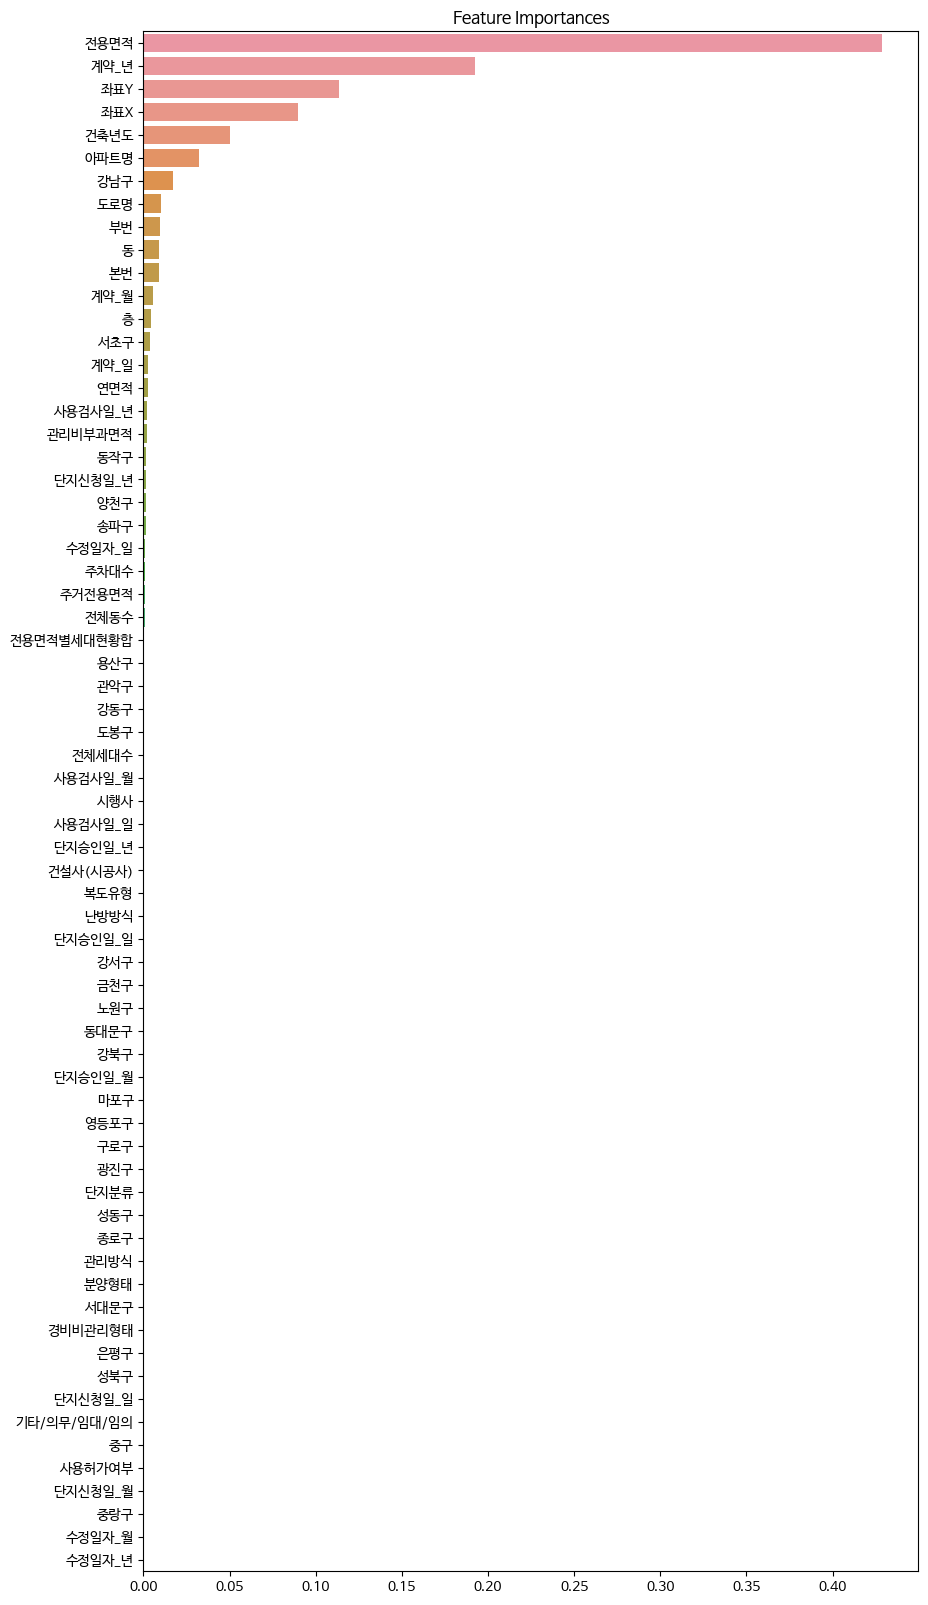

In [47]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(x_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,20))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [48]:
from sklearn.metrics import r2_score

# R² 사용자 정의 평가 함수
def r2_eval(preds, dtrain):
    labels = dtrain.get_label()  # 실제 값
    r2 = r2_score(labels, preds)  # R² 계산
    return 'r2', r2

In [50]:
# DMatrix 생성
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

# 파라미터 설정 (기본값 유지)
params = {
    'objective': 'reg:squarederror',  # 회귀 문제
    'eval_metric': 'rmse',            # 기본 RMSE
    'max_depth': 6,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'min_child_weight': 3,
    'gamma': 0.1,
    'random_state': random_state
}

# 평가 데이터셋 설정
evals = [(dtrain, 'train'), (dtest, 'eval')]

# 모델 학습
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=10000,
    evals=evals,
    early_stopping_rounds=100,
    verbose_eval=True,
    feval=r2_eval,  # 사용자 정의 평가 함수만 사용
    maximize=True   # R²는 높은 값이 더 좋은 성능
)

/opt/conda/lib/python3.10/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:0.61804	train-r2:0.05325	eval-rmse:0.61929	eval-r2:0.05313
[1]	train-rmse:0.59635	train-r2:0.11853	eval-rmse:0.59754	eval-r2:0.11847
[2]	train-rmse:0.57480	train-r2:0.18107	eval-rmse:0.57593	eval-r2:0.18107
[3]	train-rmse:0.55433	train-r2:0.23838	eval-rmse:0.55542	eval-r2:0.23837
[4]	train-rmse:0.53569	train-r2:0.28873	eval-rmse:0.53673	eval-r2:0.28876
[5]	train-rmse:0.51736	train-r2:0.33658	eval-rmse:0.51834	eval-r2:0.33666
[6]	train-rmse:0.50010	train-r2:0.38011	eval-rmse:0.50102	eval-r2:0.38024
[7]	train-rmse:0.48787	train-r2:0.41004	eval-rmse:0.48881	eval-r2:0.41009
[8]	train-rmse:0.47427	train-r2:0.44247	eval-rmse:0.47510	eval-r2:0.44272
[9]	train-rmse:0.46260	train-r2:0.46957	eval-rmse:0.46344	eval-r2:0.46972
[10]	train-rmse:0.44862	train-r2:0.50115	eval-rmse:0.44943	eval-r2:0.50131
[11]	train-rmse:0.43680	train-r2:0.52711	eval-rmse:0.43752	eval-r2:0.52738
[12]	train-rmse:0.42348	train-r2:0.55550	eval-rmse:0.42415	eval-r2:0.55583
[13]	train-rmse:0.41125	train-r2:0.

In [51]:
# 최종 특성 중요도 확인
importance = model.get_score(importance_type='weight')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

# 결과 출력
print("Feature Importance:\n", importance_df)

# 과적합 방지: 성능 확인
y_pred = model.predict(dtest)
rmse = np.sqrt(((y_pred - y_test) ** 2).mean())
print(f"Final RMSE on Test Set: {rmse}")

Feature Importance:
         Feature  Importance
31         전용면적      7954.0
32         계약_년      7209.0
2           좌표Y      6944.0
3           좌표X      6756.0
30         아파트명      6385.0
..          ...         ...
65      단지신청일_일        37.0
64      단지신청일_월        28.0
59  기타/의무/임대/임의        20.0
54       수정일자_년         4.0
55       수정일자_월         3.0

[66 rows x 2 columns]
Final RMSE on Test Set: 0.09383690212758423


In [52]:
import pickle

# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model/saved_model_09.pkl', 'wb') as f:
    pickle.dump(model, f)

In [53]:
real_test = xgb.DMatrix(test)
real_test_pred = model.predict(real_test)
real_test_pred = np.expm1(real_test_pred)
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])

In [54]:
preds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9272 entries, 0 to 9271
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  9272 non-null   int64
dtypes: int64(1)
memory usage: 72.6 KB


In [55]:
preds_df

,target
0,191015
1,289844
2,318178
3,254980
4,220768
...,...
9267,73397
9268,73032
9269,83162
9270,70442


In [56]:
preds_df.to_csv('../data/sub/output_xgboost_009.csv', index=False)